# BUSINESS PROBLEM -  HUMAN RESOURCES ANALYTICS

# 0.0. IMPORTS

In [216]:
import pandas                as pd
import numpy                 as np
import datetime
from IPython.display         import Image
from IPython.core.display    import HTML
import glob
from minio                   import Minio
import seaborn               as sns
import matplotlib.pyplot     as plt
import warnings
import joblib
import pickle
#from pycaret.classification  import *

from boruta                  import BorutaPy
from scikitplot              import metrics      as mt
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score,cross_val_predict,RandomizedSearchCV
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import accuracy_score, classification_report,cohen_kappa_score,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from sklearn.linear_model    import LogisticRegression
import xgboost               as xgb
from lightgbm                import LGBMClassifier

In [133]:
warnings.filterwarnings("ignore")

## 0.1. Loading Data

In [2]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

In [5]:
#baixando os dados diretamento do nosso data lake 
client.fget_object(
            "processing",
            "employees_dataset.parquet",
            "temp_.parquet",
)
df_raw = pd.read_parquet("temp_.parquet")

In [6]:
df_raw.head()

department  salary  left department.1 salary.1  left.1  \
0      sales     low   1.0        sales      low     1.0   
1      sales  medium   1.0        sales   medium     1.0   
2      sales  medium   1.0        sales   medium     1.0   
3      sales     low   1.0        sales      low     1.0   
4      sales     low   1.0        sales      low     1.0   

   mean_work_last_3_months  number_projects  satisfaction_level  \
0               266.000000              2.0                38.0   
1               252.000000              5.0                80.0   
2               289.666667              7.0                11.0   
3               275.666667              5.0                72.0   
4               292.333333              2.0                37.0   

   last_evaluation   hire_date  time_in_company  work_accident  
0             53.0  2018-01-17              3.0            0.0  
1             86.0  2015-02-02              6.0            0.0  
2             88.0  2017-01-22              4.0            0.0  
3             87.0  2016-01-28              5.0            0.0  
4             52.0  2018-01-17              3.0            0.0

In [7]:
df = df_raw[['department', 'salary', 'mean_work_last_3_months',
       'number_projects', 'satisfaction_level', 'last_evaluation',
       'time_in_company', 'work_accident','left']]

In [8]:
df.head()

department  salary  mean_work_last_3_months  number_projects  \
0      sales     low               266.000000              2.0   
1      sales  medium               252.000000              5.0   
2      sales  medium               289.666667              7.0   
3      sales     low               275.666667              5.0   
4      sales     low               292.333333              2.0   

   satisfaction_level  last_evaluation  time_in_company  work_accident  left  
0                38.0             53.0              3.0            0.0   1.0  
1                80.0             86.0              6.0            0.0   1.0  
2                11.0             88.0              4.0            0.0   1.0  
3                72.0             87.0              5.0            0.0   1.0  
4                37.0             52.0              3.0            0.0   1.0

## 0.2. Helper Functions

In [35]:
def descriptive_statistical(num_attributes):
    #Central Tendency - Mean, Median
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    #Dispersion - Std, Min, Max, Range, Skew, Kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    
    m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
    m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return m 

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [38]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0. DATA DESCRIPTION

In [9]:
df1 = df.copy()

## 1.1. Data Dimension

In [11]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 15000
Number of columns: 9


## 1.2. Check NA 

In [12]:
df1.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [13]:
df1 = df1.dropna()

In [14]:
df1.shape

(14999, 9)

## 1.3. Data Types

In [15]:
df1.dtypes

department                  object
salary                      object
mean_work_last_3_months    float64
number_projects            float64
satisfaction_level         float64
last_evaluation            float64
time_in_company            float64
work_accident              float64
left                       float64
dtype: object

In [16]:
df1["number_projects"] = df1["number_projects"].astype(int)
df1["mean_work_last_3_months"] = df1["mean_work_last_3_months"].astype(int)
df1["time_in_company"] = df1["time_in_company"].astype(int)
df1["work_accident"] = df1["work_accident"].astype(int)
df1["left"] = df1["left"].astype(int)

In [17]:
df1.dtypes

department                  object
salary                      object
mean_work_last_3_months      int32
number_projects              int32
satisfaction_level         float64
last_evaluation            float64
time_in_company              int32
work_accident                int32
left                         int32
dtype: object

## 1.4. Rename Columns

In [18]:
df1 = df1.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

In [19]:
df1.head()

department  salary  averageMonthlyHours  projectCount  satisfaction  \
0      sales     low                  266             2          38.0   
1      sales  medium                  252             5          80.0   
2      sales  medium                  289             7          11.0   
3      sales     low                  275             5          72.0   
4      sales     low                  292             2          37.0   

   evaluation  yearsAtCompany  workAccident  turnover  
0        53.0               3             0         1  
1        86.0               6             0         1  
2        88.0               4             0         1  
3        87.0               5             0         1  
4        52.0               3             0         1

## 1.5. Descriptive Statistical

In [25]:
num_attributes = df1.select_dtypes(include = ['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','int32'])

### 1.5.1. Numerical Attributes

In [32]:
descriptive_statistical(num_attributes)

attributes    min    max  range        mean  median        std  \
0  averageMonthlyHours  232.0  321.0   89.0  275.685579   276.0  10.054340   
1         projectCount    2.0    7.0    5.0    3.803054     4.0   1.232551   
2         satisfaction    9.0  100.0   91.0   61.283352    64.0  24.862236   
3           evaluation   36.0  100.0   64.0   71.610174    72.0  17.116340   
4       yearsAtCompany    2.0   10.0    8.0    3.498233     3.0   1.460088   
5         workAccident    0.0    1.0    1.0    0.144610     0.0   0.351707   
6             turnover    0.0    1.0    1.0    0.238083     0.0   0.425910   

       skew  kurtosis  
0  0.000228  0.038315  
1  0.337706 -0.495478  
2 -0.476360 -0.670859  
3 -0.026622 -1.239040  
4  1.853319  4.773211  
5  2.021149  2.085320  
6  1.230043 -0.487060

### 1.5.2. Categorical Attributes

In [33]:
cat_attributes

department  salary
0          sales     low
1          sales  medium
2          sales  medium
3          sales     low
4          sales     low
...          ...     ...
14994      sales     low
14995  technical     low
14996  technical  medium
14997    support     low
14998    support     low

[14999 rows x 2 columns]

<AxesSubplot:xlabel='turnover', ylabel='count'>

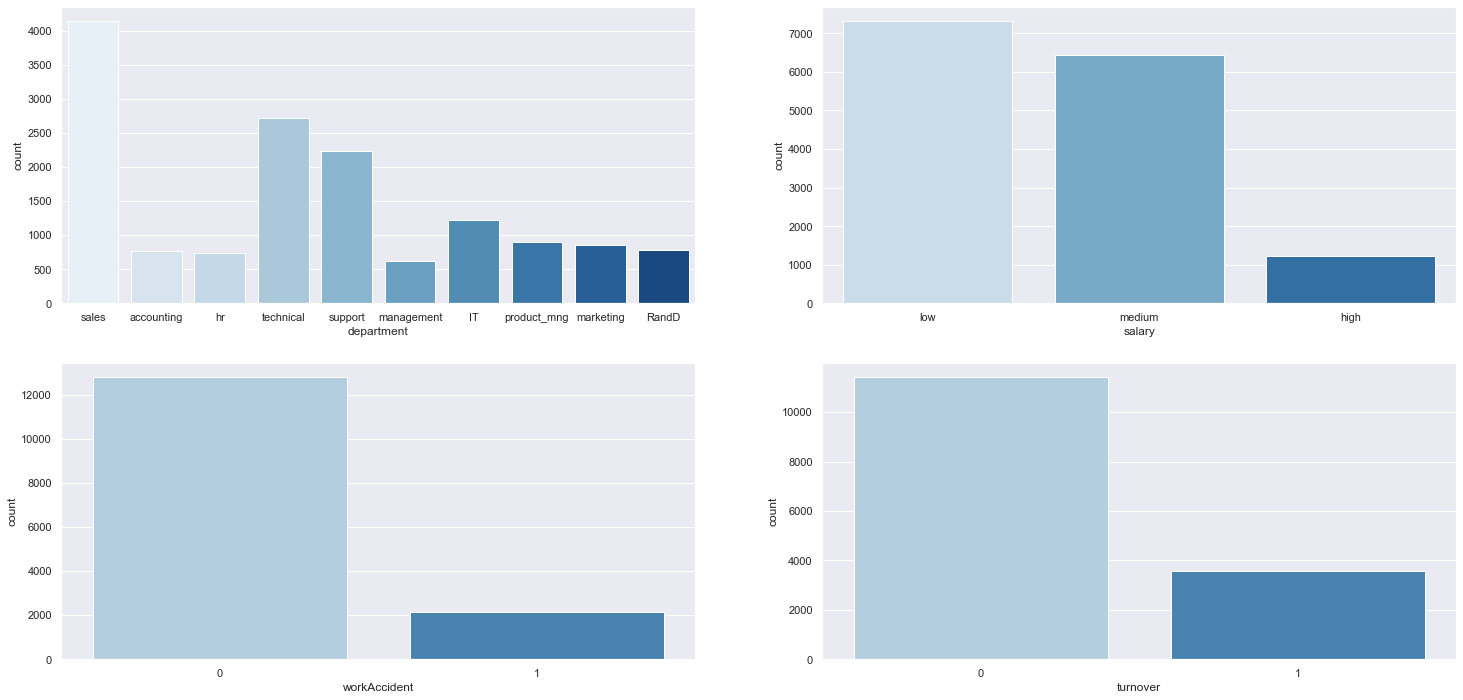

In [48]:
plt.subplot(2,2,1)
sns.countplot(x = 'department',data = cat_attributes, palette = 'Blues')

plt.subplot(2,2,2)
sns.countplot(x = 'salary',data = cat_attributes, palette = 'Blues')

plt.subplot(2,2,3)
sns.countplot(x = 'workAccident',data = df1, palette = 'Blues')

plt.subplot(2,2,4)
sns.countplot(x = 'turnover',data = df1, palette = 'Blues')

# 2.0. EXPLORATORY DATA ANALYSIS

In [51]:
#checkpoint
df2 = df1.copy()

## 2.1. Univariate Analysis

### 2.1.1. Numerical Attributes

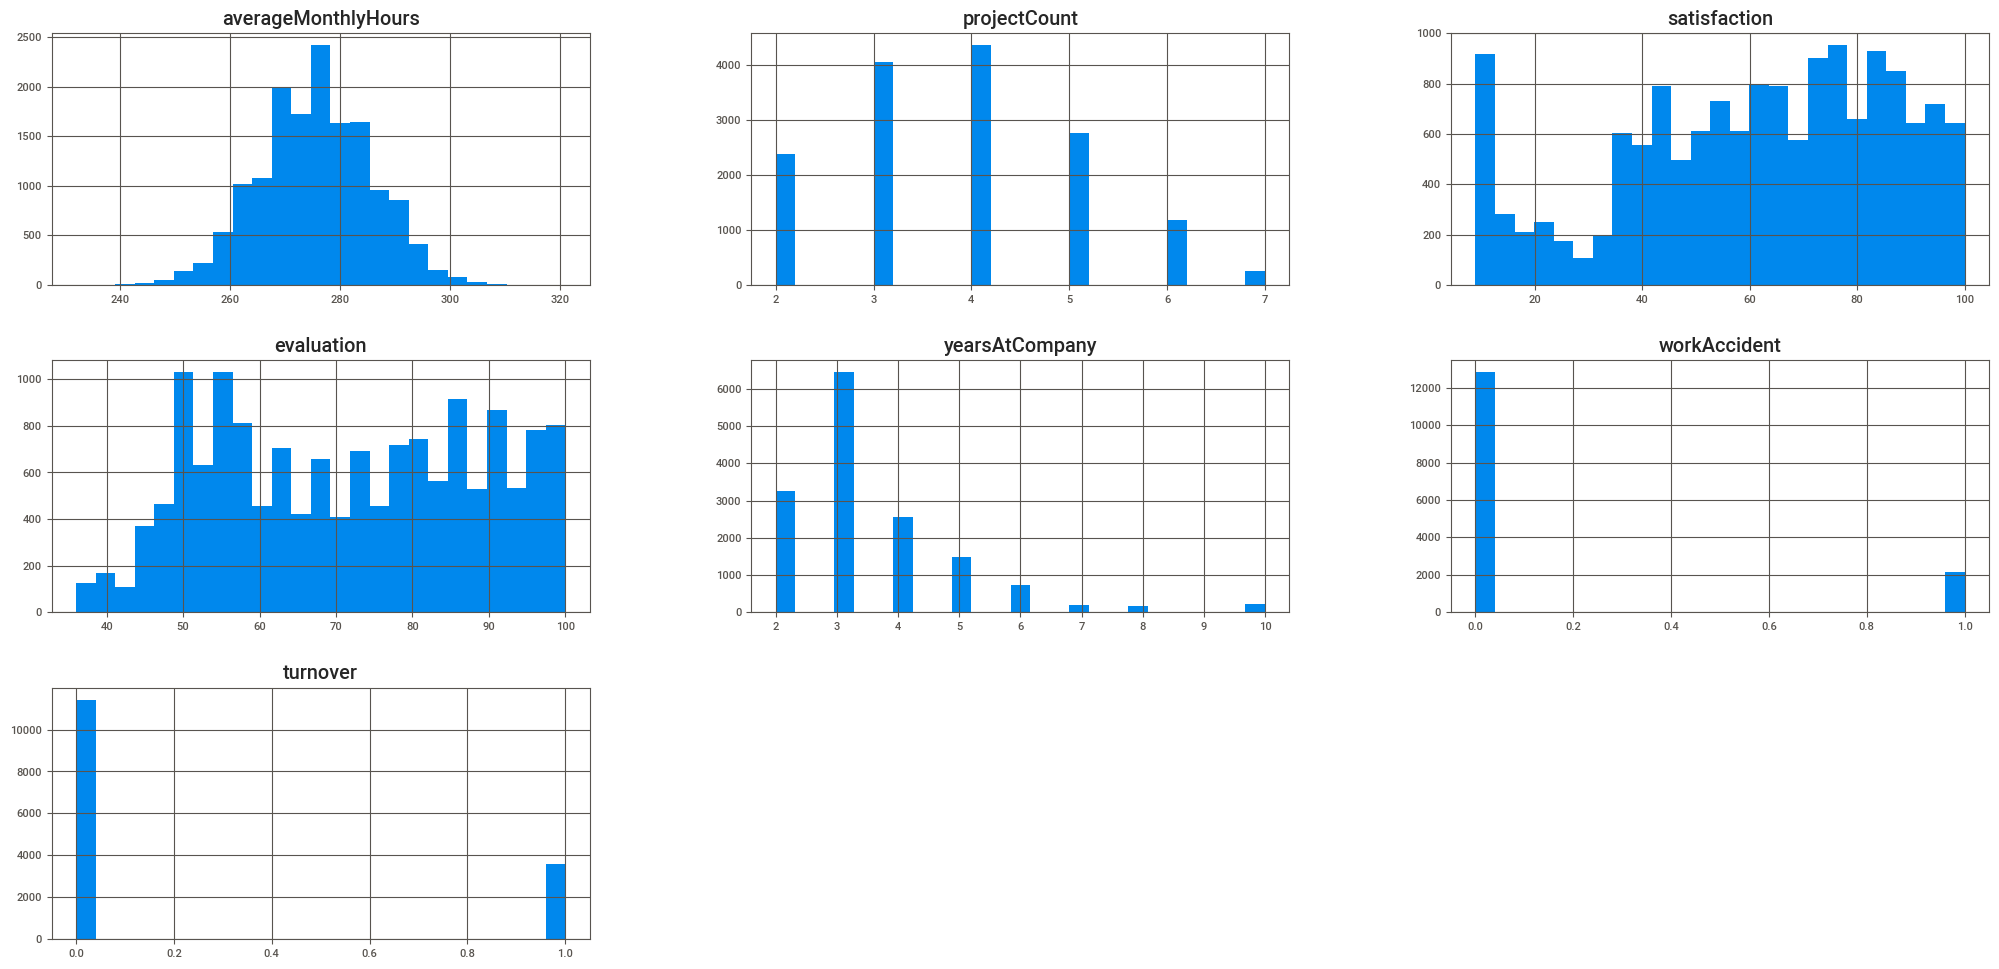

In [59]:
colunas = ['averageMonthlyHours', 'projectCount','satisfaction', 'evaluation', 'yearsAtCompany', 'workAccident','turnover']

#plotagem do histograma
df2[colunas].hist(bins = 25);

### 2.1.2. Response Variable

Text(0.5, 1.0, 'Turnover Contagem')

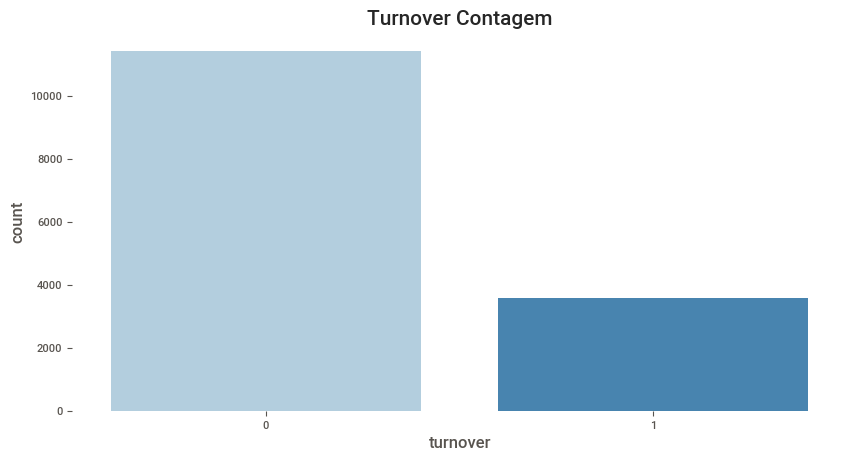

In [64]:
plt.figure(figsize = (10,5 ))
sns.countplot(x = 'turnover',data = df2, palette = 'Blues')
plt.box(False)
plt.title("Turnover Contagem", fontsize = 15)

In [66]:
turnover_rate = df2['turnover'].value_counts() / len(df2)
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

## 2.2. Bivariate Analysis

### H1. Pessoas com alta quantidade de horas mensais possuem um maior percentual de Turnover

In [70]:
df2[['averageMonthlyHours','turnover']].groupby("turnover").mean().reset_index()

turnover  averageMonthlyHours
0         0           275.669758
1         1           275.736208

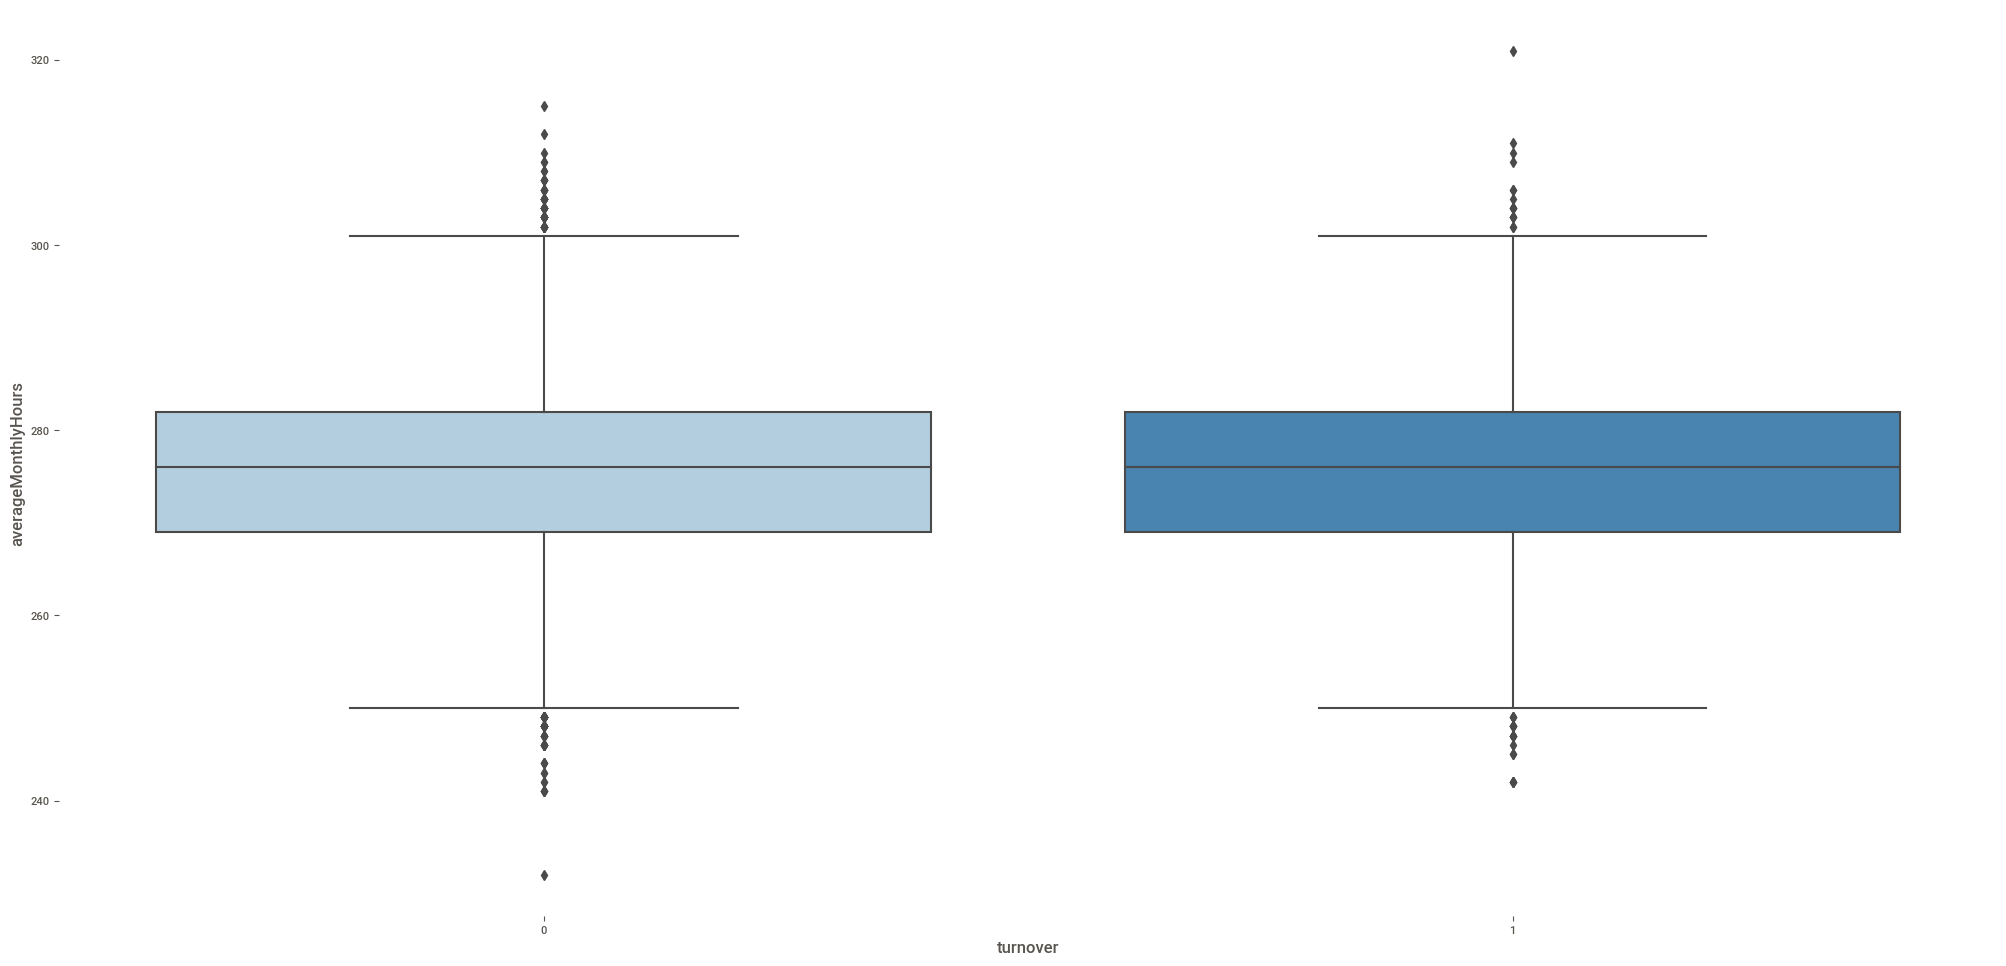

In [118]:
sns.boxplot(x = 'turnover', y = 'averageMonthlyHours', data = df2, palette = 'Blues')
plt.box(False)

C:\Users\jorge\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


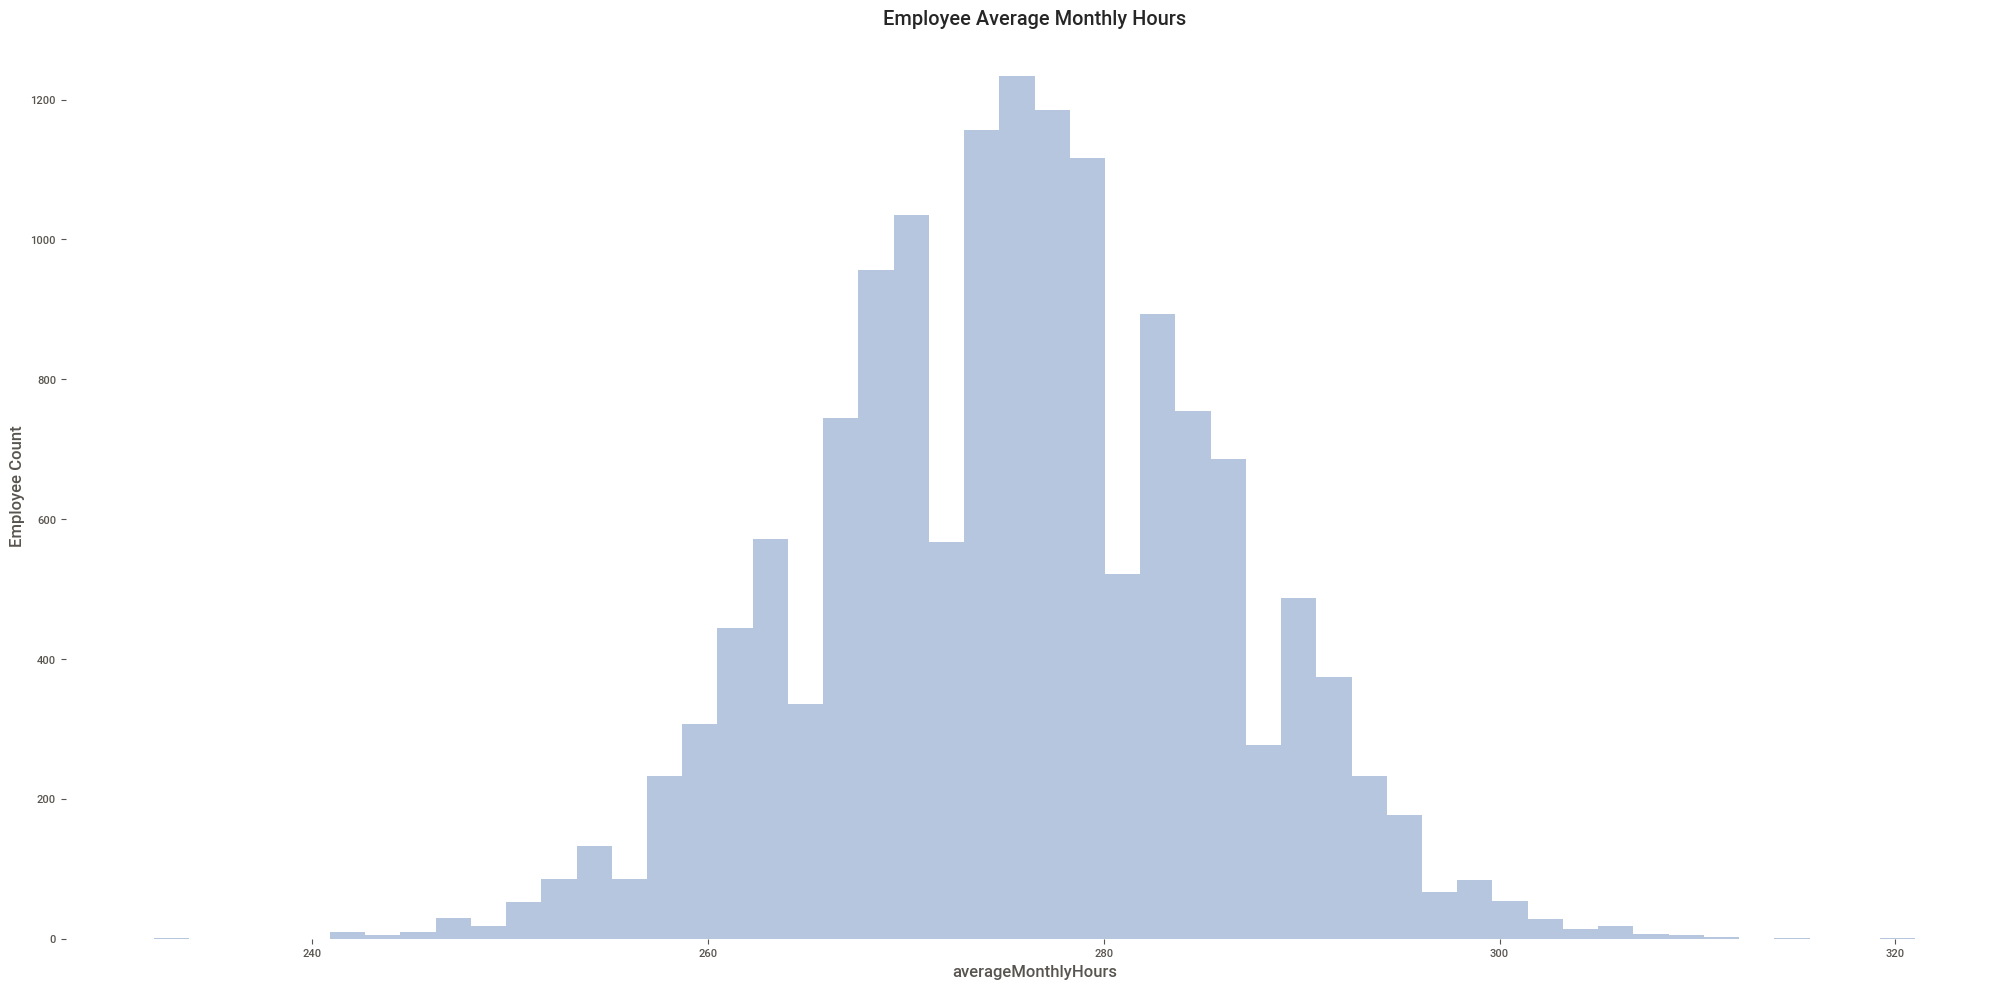

In [117]:
sns.distplot(df2.averageMonthlyHours, kde=False, color="b").set_title('Employee Average Monthly Hours')
plt.ylabel('Employee Count')
plt.box(False)
plt.show()

In [72]:
turnover_summary = df2.groupby('turnover')
turnover_summary.mean()

averageMonthlyHours  projectCount  satisfaction  evaluation  yearsAtCompany  workAccident
turnover                                                                                           
0                  275.669758      3.793227     64.888869   71.585054        3.401208      0.162583
1                  275.736208      3.834500     49.744889   71.690563        3.808737      0.087090

O conjunto de dados tem:

- 14.998 observações de empregados e 9 atributos.
- A empresa tem uma rotatividade de 24%.
- A satisfação média dos empregados é de 61.
-- A satisfação média dos empregados que deixaram a empresa é 49.

É possível identificar que há uma semelhança entre os que entraram e turnover e os que não entraram quando comaprado com a quantiadade de horas trabalhadas no mês.

**AverageMonthlyHours** - A concentração da quantidade de horas trabalhadas nos últimos 3 meses está ao redor da média em 275 horas.

### H2. Quanto menor o salário, maior a probabilidade do turnover

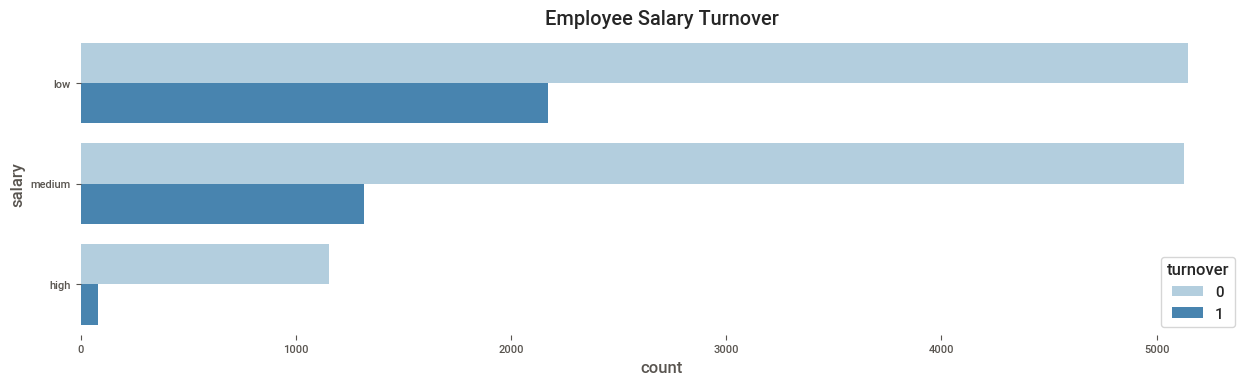

In [116]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(y="salary", hue='turnover', data=df2, palette = 'Blues').set_title('Employee Salary Turnover');
plt.box(False)

**Summary:**
 - A maioria dos empregados que saíram tinha salário **baixo** ou **médio**.
 - Quase nenhum empregado com alto salário deixou a empresa.
 
**Questões:** 
 - Como é o ambiente de trabalho? Isso se difere por salário?
 - O que faz empregados com alto salário sairem da empresa.

### H3. O derpatamento de tecnologia é o que possui maior quantidade de funcionários que entraram e turnover.

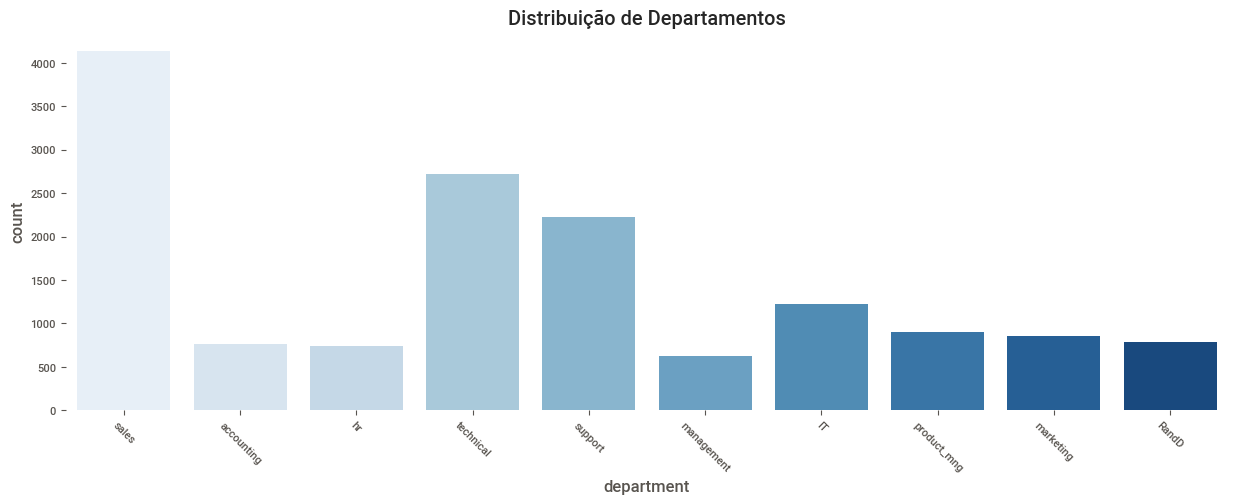

In [115]:
f, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation=-45)
sns.countplot(x='department', data=df2, palette='Blues').set_title('Distribuição de Departamentos');
plt.box(False)

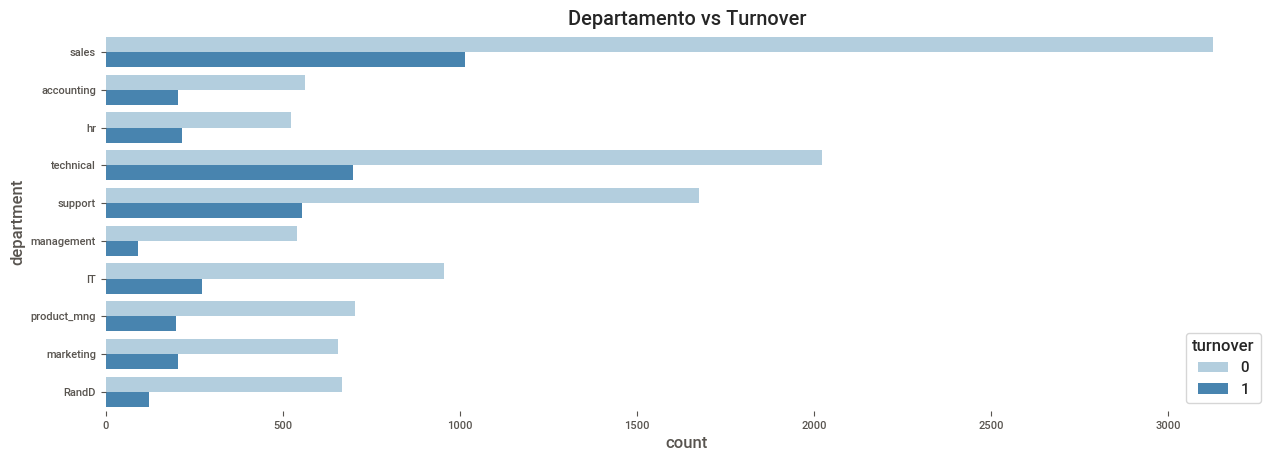

In [113]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="department", hue='turnover', data=df2, palette = 'Blues').set_title('Departamento vs Turnover');
plt.box(False)

***
**Resumo:** Vamos ver mais informações sobre os departamentos da empresa.
 - Os departamentos de vendas, técnico e suporte são top 3 departamentos com maior índice de turnover.
 - O departamento management tem o menor volume de turnover.

**Questões:** 
 - Será que examinar em profundidade os departamentos que tem maior índice de turnover e o menor pode nos revelar mais    informações importantes?
 - Qual o salário nestes departamentos?

### H4. Funcionários envolvidos em poucos projetos possuem maior probabilidade de turnover

[]

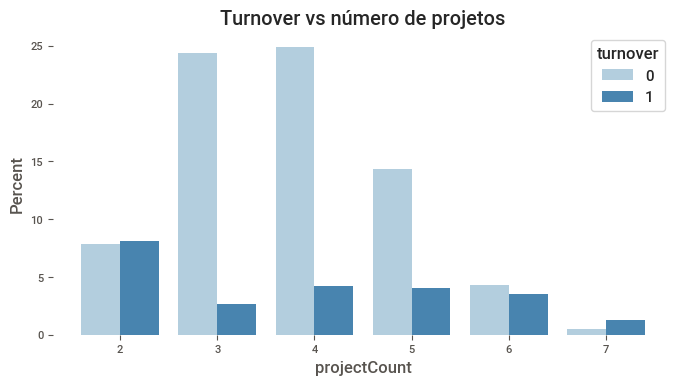

In [92]:
fig = plt.figure(figsize=(8,4),)
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=df2, estimator=lambda x: len(x) / len(df2) * 100, palette = 'Blues')
ax.set(ylabel="Percent")
plt.title('Turnover vs número de projetos')
plt.box(False)
plt.plot()

### H5. Funcionários com baixo nível de satisfação entram em turnover.

C:\Users\jorge\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Employee Count')

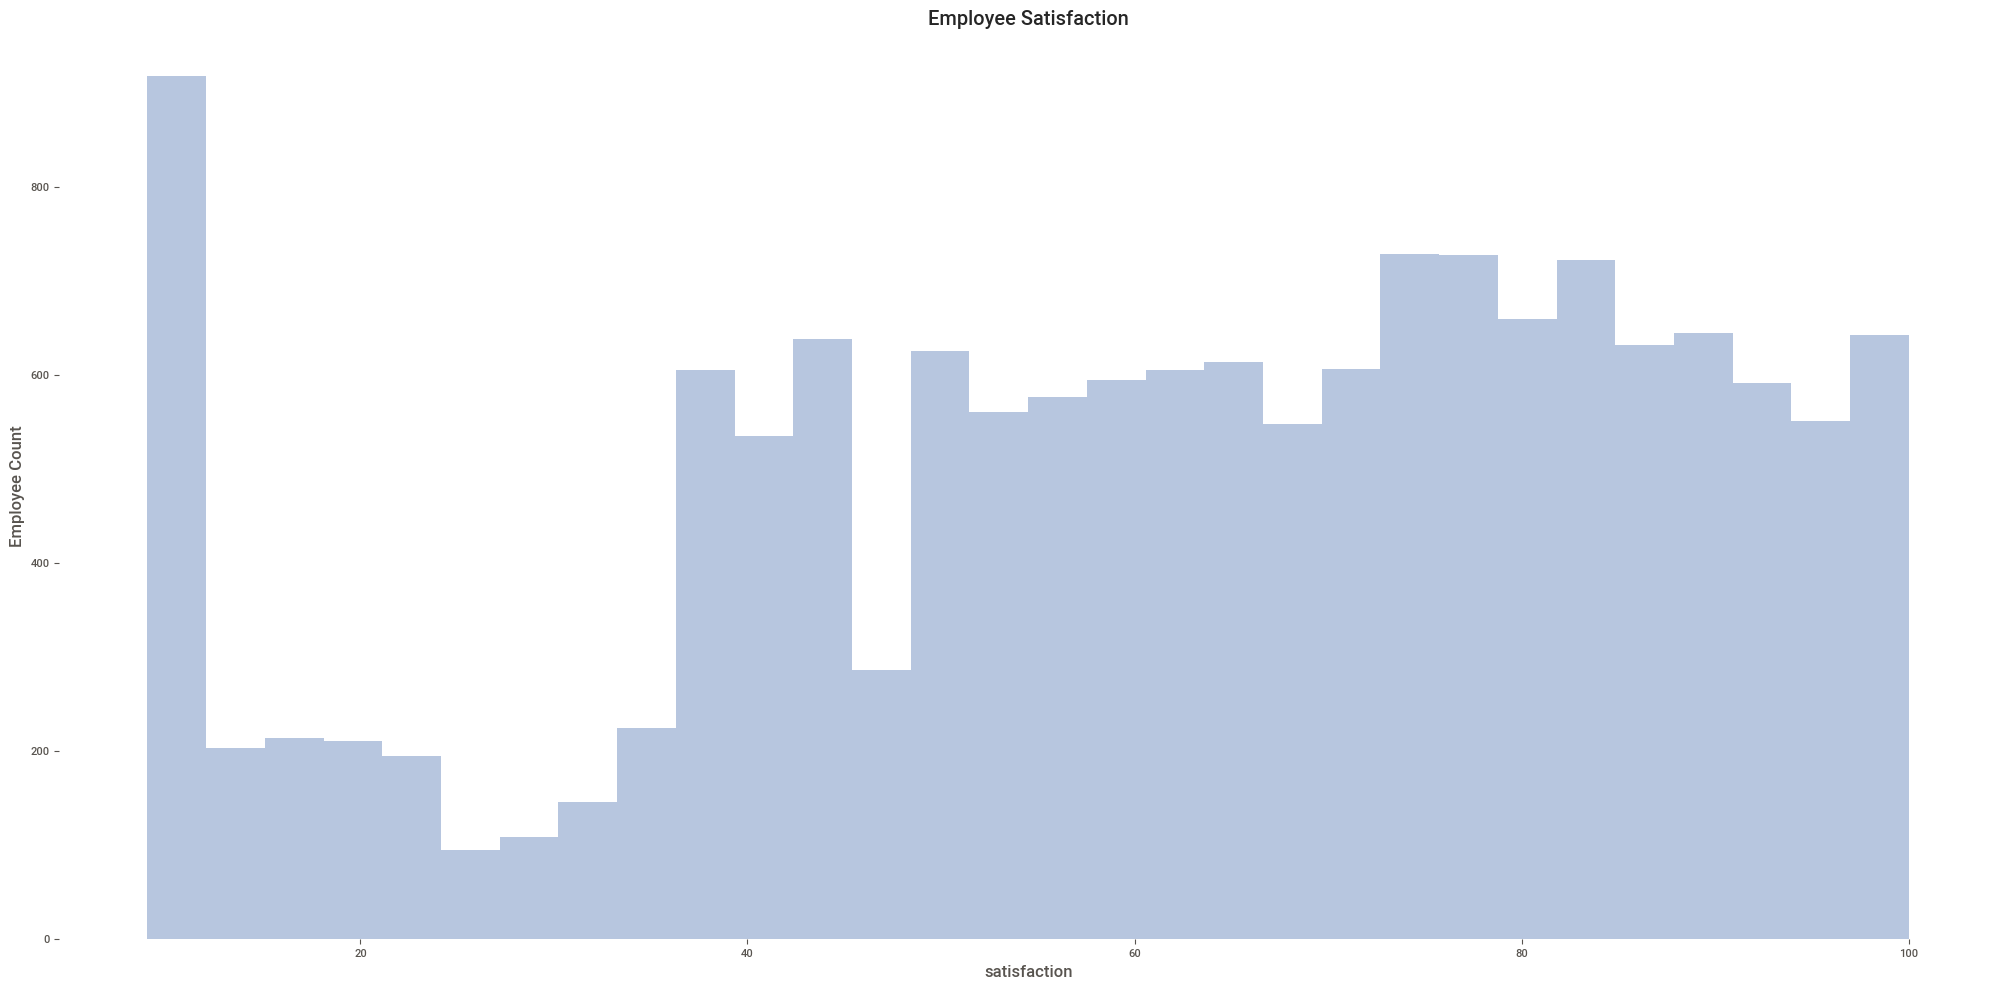

In [112]:
sns.distplot(df2.satisfaction, kde=False, color="b").set_title('Employee Satisfaction')
plt.box(False)
plt.ylabel('Employee Count')

[]

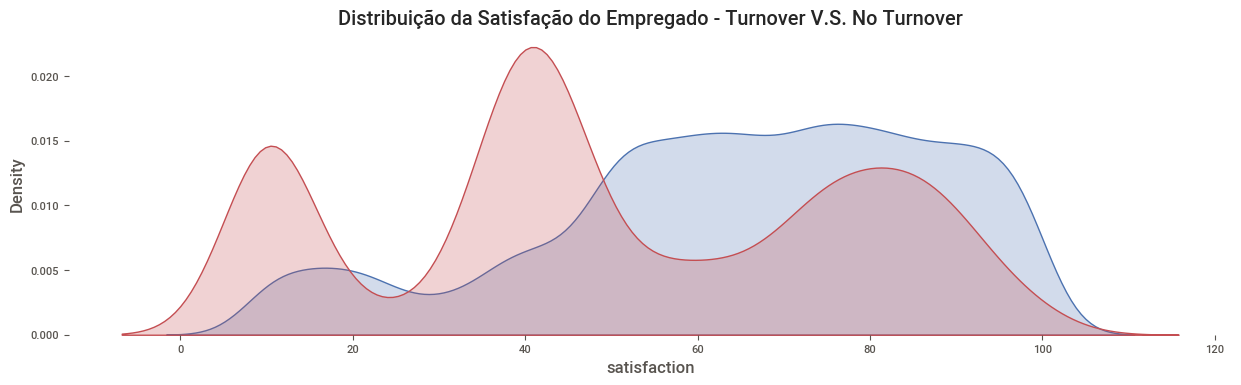

In [111]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df2.loc[(df2['turnover'] == 0),'satisfaction'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df2.loc[(df2['turnover'] == 1),'satisfaction'] , color='r',shade=True, label='turnover')
plt.title('Distribuição da Satisfação do Empregado - Turnover V.S. No Turnover')
plt.box(False)
plt.plot()

**Summary:** Examinando a distribuição de alguns atributos do conjunto de dados:
 - **Satisfaction** - Existe um pico de empregados com baixa satisfação mas a maior concentração está em 60 a 80.
 - **Evaluation** - Temos uma distribuição bimodal de empregados com avaliações baixas, menor que de 60 e altas, maior que 80.
 - **AverageMonthlyHours** - A concentração da quantidade de horas trabalhadas nos últimos 3 meses está ao redor da média em 275 horas.
 
**Resumo:** 
 - Empregados com o nível de satisfação em 20 ou menos tendem a deixar a empresa.
 - Empregados com o nível de satisfação em até 50 tem maior probabilidade de deixar a empresa.
 
**Questões:** 
 - Existe uma razão para o pico de empregados insatisfeitos?

### H6. Avaliações baixas provocam um aumento no número de turnover

Text(0, 0.5, 'Employee Count')

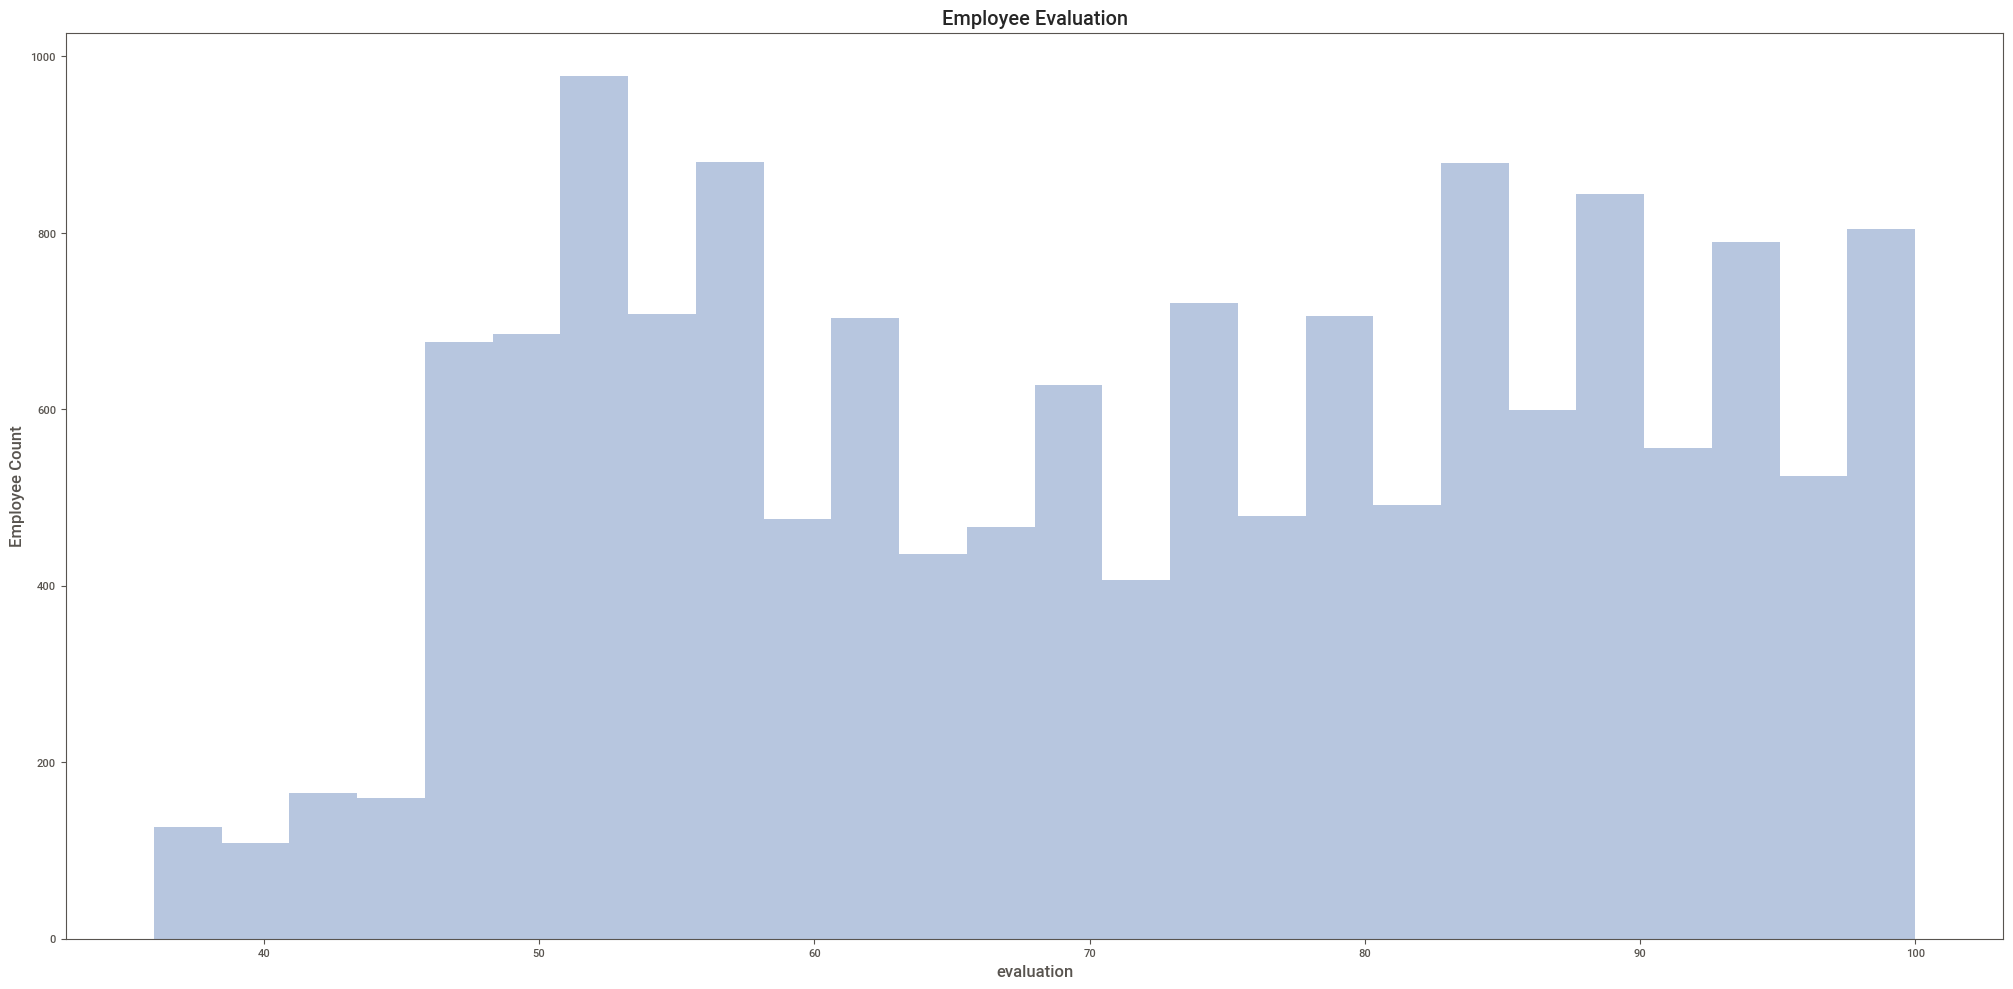

In [102]:
sns.distplot(df2.evaluation, kde=False, color="b").set_title('Employee Evaluation')
plt.ylabel('Employee Count')

[]

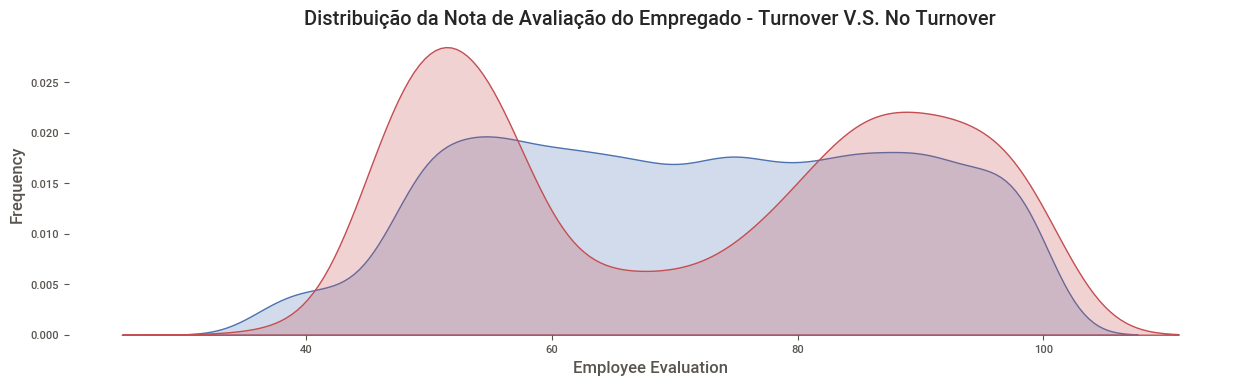

In [110]:
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df2.loc[(df2['turnover'] == 0),'evaluation'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df2.loc[(df2['turnover'] == 1),'evaluation'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Evaluation', ylabel='Frequency')
plt.title('Distribuição da Nota de Avaliação do Empregado - Turnover V.S. No Turnover')
plt.box(False)
plt.plot()

**Resumo:** 
 - Temos uma distribuição bimodal para o conjunto que deixou a empresa.
 - Colaboradores com **baixa performance** tendem a deixar a empresa.
 - Colaboradores com **alta performance** tendem a deixar a empresa.
 - O **ponto ideal** para os funcionários que permaneceram está dentro da avaliação de 60 à 80.

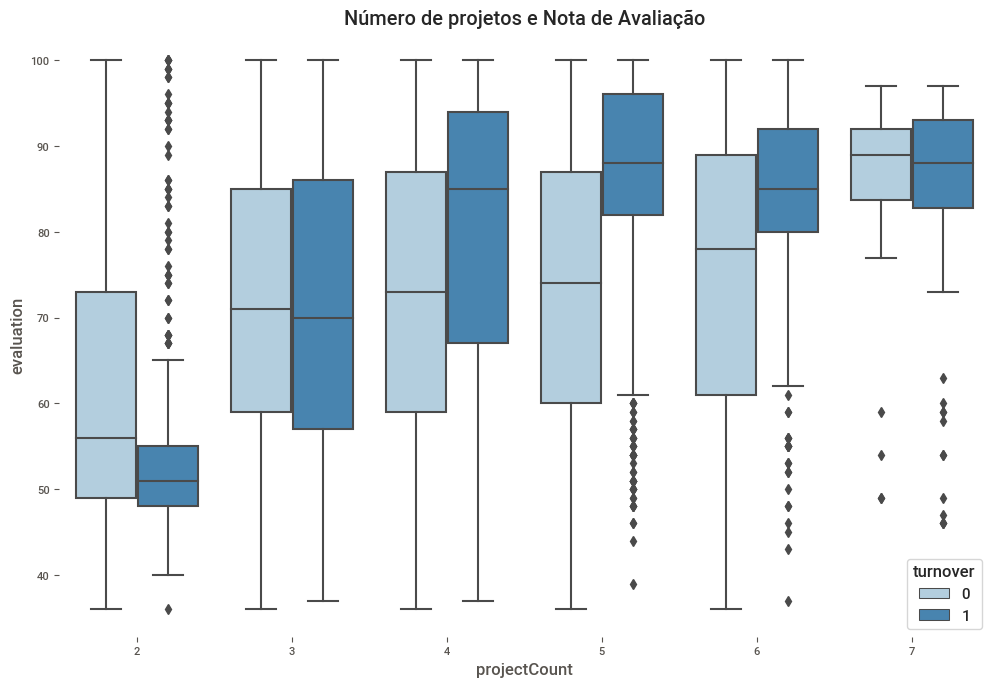

In [126]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(x="projectCount", y="evaluation", hue="turnover", data=df2, palette = 'Blues')
plt.title("Número de projetos e Nota de Avaliação")
plt.box(False)
plt.show()

***
**Resumo:** 
- Há um **aumento na avaliação** para os funcionários que realizaram mais projetos dentro do grupo de quem deixou a empresa. 
- Para o grupo de pessoas que permaneceram na empresa, os empregados tiveram uma **pontuação de avaliação consistente**, apesar do aumento nas contagens de projetos.
- Empregados que permaneceram na empresa tiveram uma **avaliação média em torno de 70%**, mesmo com o número de projetos crescendo.
- Esta relação muda drasticamente entre os empregados que deixaram a empresa. A partir de 3 projetos, as **médias de avaliação aumentam consideravelmente**.
- Empregados que tinham **dois projetos e uma péssima avaliação** saíram.
- Empregados com **mais de 3 projetos e avaliações altas** deixaram a empresa.

**Questões:**
  - Por que será que os funcionários que saíram tiveram em média uma avaliação superior aos funcionários que não saíram, mesmo com um aumento no número de projetos?
  - Os funcionários com avaliações mais baixas não deveriam ter tendência a sair mais da empresa?

### H7. Há uma maior concentração de turnover em funcionários com menos tempo de empresa

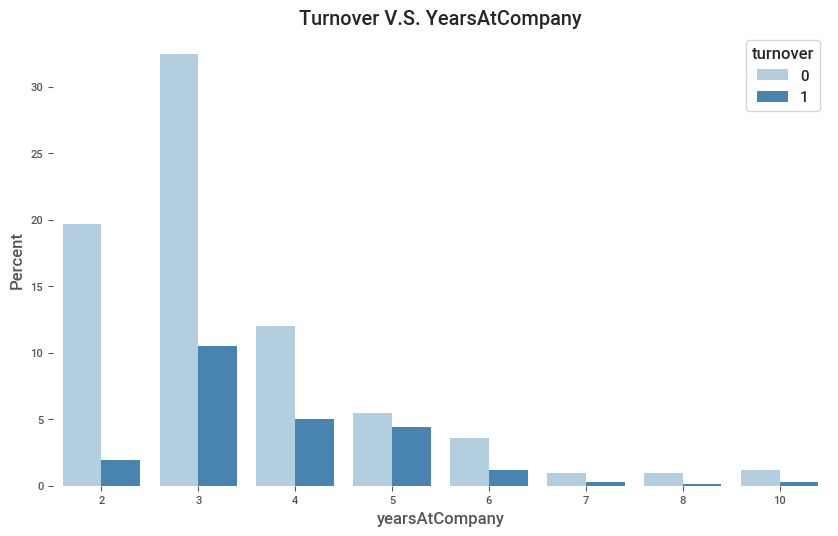

In [107]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x="yearsAtCompany", y="yearsAtCompany", hue="turnover", data=df2, estimator=lambda x: len(x) / len(df) * 100, palette = 'Blues')
ax.set(ylabel="Percent")
plt.title("Turnover V.S. YearsAtCompany")
plt.box(False)
plt.show()

**Resumo:** Vamos ver mais alguns pontos para entender o porque os empregados deixam a empresa.
 - Empregados com **4 e 5 anos de casa** deixaram a empresa.
 - Empregados acima de **5 anos de casa** devem ser examinados.
 
**Questões:**
  - Por que os Empregados estão saindo principalmente na faixa de 3-5 anos?
  - Quem são esses Empregados que saíram?

# Sweetviz

In [50]:
import sweetviz as sv

my_report = sv.analyze(df2,"turnover")
my_report.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# 3.0. DATA PREPARATION

In [119]:
df3 = df2.copy()

## 3.1. Encoding

In [122]:
#department
df3['department'] = df3['department'].astype("category").cat.codes

#salary
df3['salary'] = df3['salary'].astype("category").cat.codes

In [123]:
df3.head()

department  salary  averageMonthlyHours  projectCount  satisfaction  evaluation  yearsAtCompany  workAccident  turnover
0           7       1                  266             2          38.0        53.0               3             0         1
1           7       2                  252             5          80.0        86.0               6             0         1
2           7       2                  289             7          11.0        88.0               4             0         1
3           7       1                  275             5          72.0        87.0               5             0         1
4           7       1                  292             2          37.0        52.0               3             0         1

## 3.2. Split data into training and test

In [124]:
target_name = 'turnover'
X = df3.drop(columns = target_name, axis =1)
y = df3[target_name]

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## 3.3. Rescaling

In [218]:
#department
department_scaler = MinMaxScaler()
X_train['department'] = department_scaler.fit_transform(X_train[['department']])
X_test['department'] = department_scaler.transform(X_test[['department']])
pickle.dump(department_scaler, open("department_scaler.pkl", "wb"))

#salary
salary_scaler = MinMaxScaler()
X_train['salary'] = salary_scaler.fit_transform(X_train[['salary']])
X_test['salary'] = salary_scaler.transform(X_test[['salary']])
pickle.dump(salary_scaler, open("salary_scaler.pkl", "wb"))

#averageMonthlyHours
averageMonthlyHours_scaler = MinMaxScaler()
X_train['averageMonthlyHours'] = averageMonthlyHours_scaler.fit_transform(X_train[['averageMonthlyHours']])
X_test['averageMonthlyHours'] = averageMonthlyHours_scaler.transform(X_test[['averageMonthlyHours']])
pickle.dump(averageMonthlyHours_scaler, open("averageMonthlyHours_scaler.pkl", "wb"))

#projectCount
projectCount_scaler = MinMaxScaler()
X_train['projectCount'] = projectCount_scaler.fit_transform(X_train[['projectCount']])
X_test['projectCount'] = projectCount_scaler.transform(X_test[['projectCount']])
pickle.dump(projectCount_scaler, open("projectCount_scaler.pkl", "wb"))

#satisfaction
satisfaction_scaler = MinMaxScaler()
X_train['satisfaction'] = satisfaction_scaler.fit_transform(X_train[['satisfaction']])
X_test['satisfaction'] = satisfaction_scaler.transform(X_test[['satisfaction']])
pickle.dump(satisfaction_scaler, open("satisfaction_scaler.pkl", "wb"))

#evaluation
evaluation_scaler = MinMaxScaler()
X_train['evaluation'] = evaluation_scaler.fit_transform(X_train[['evaluation']])
X_test['evaluation'] = evaluation_scaler.transform(X_test[['evaluation']])
pickle.dump(evaluation_scaler, open("evaluation_scaler.pkl", "wb"))

#yearsAtCompany
yearsAtCompany_scaler = MinMaxScaler()
X_train['yearsAtCompany'] = yearsAtCompany_scaler.fit_transform(X_train[['yearsAtCompany']])
X_test['yearsAtCompany'] = yearsAtCompany_scaler.transform(X_test[['yearsAtCompany']])
pickle.dump(yearsAtCompany_scaler, open("yearsAtCompany_scaler.pkl", "wb"))

#workAccident
workAccident_scaler = MinMaxScaler()
X_train['workAccident'] = workAccident_scaler.fit_transform(X_train[['workAccident']])
X_test['workAccident'] = workAccident_scaler.transform(X_test[['workAccident']])
pickle.dump(workAccident_scaler, open("workAccident_scaler.pkl", "wb"))

## 3.4. Save models to data lake 

In [219]:
client.fput_object(
    "curated",
    "projectCount_scaler.pkl",
    "projectCount_scaler.pkl"
)

client.fput_object(
    "curated",
    "satisfaction_scaler.pkl",
    "satisfaction_scaler.pkl"
)

client.fput_object(
    "curated",
    "evaluation_scaler.pkl",
    "evaluation_scaler.pkl"
)

client.fput_object(
    "curated",
    "yearsAtCompany_scaler.pkl",
    "yearsAtCompany_scaler.pkl"
)

# 4.0. FEATURE SELECTION

## 4.1. Boruta as Feature Selector

In [145]:
#training and test dataset for boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestClassifier(n_jobs = -1)

#define boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	4


In [146]:
#best features from boruta
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['projectCount', 'satisfaction', 'evaluation', 'yearsAtCompany']

## 4.2. Random Forest as Feature Selector 

<AxesSubplot:>

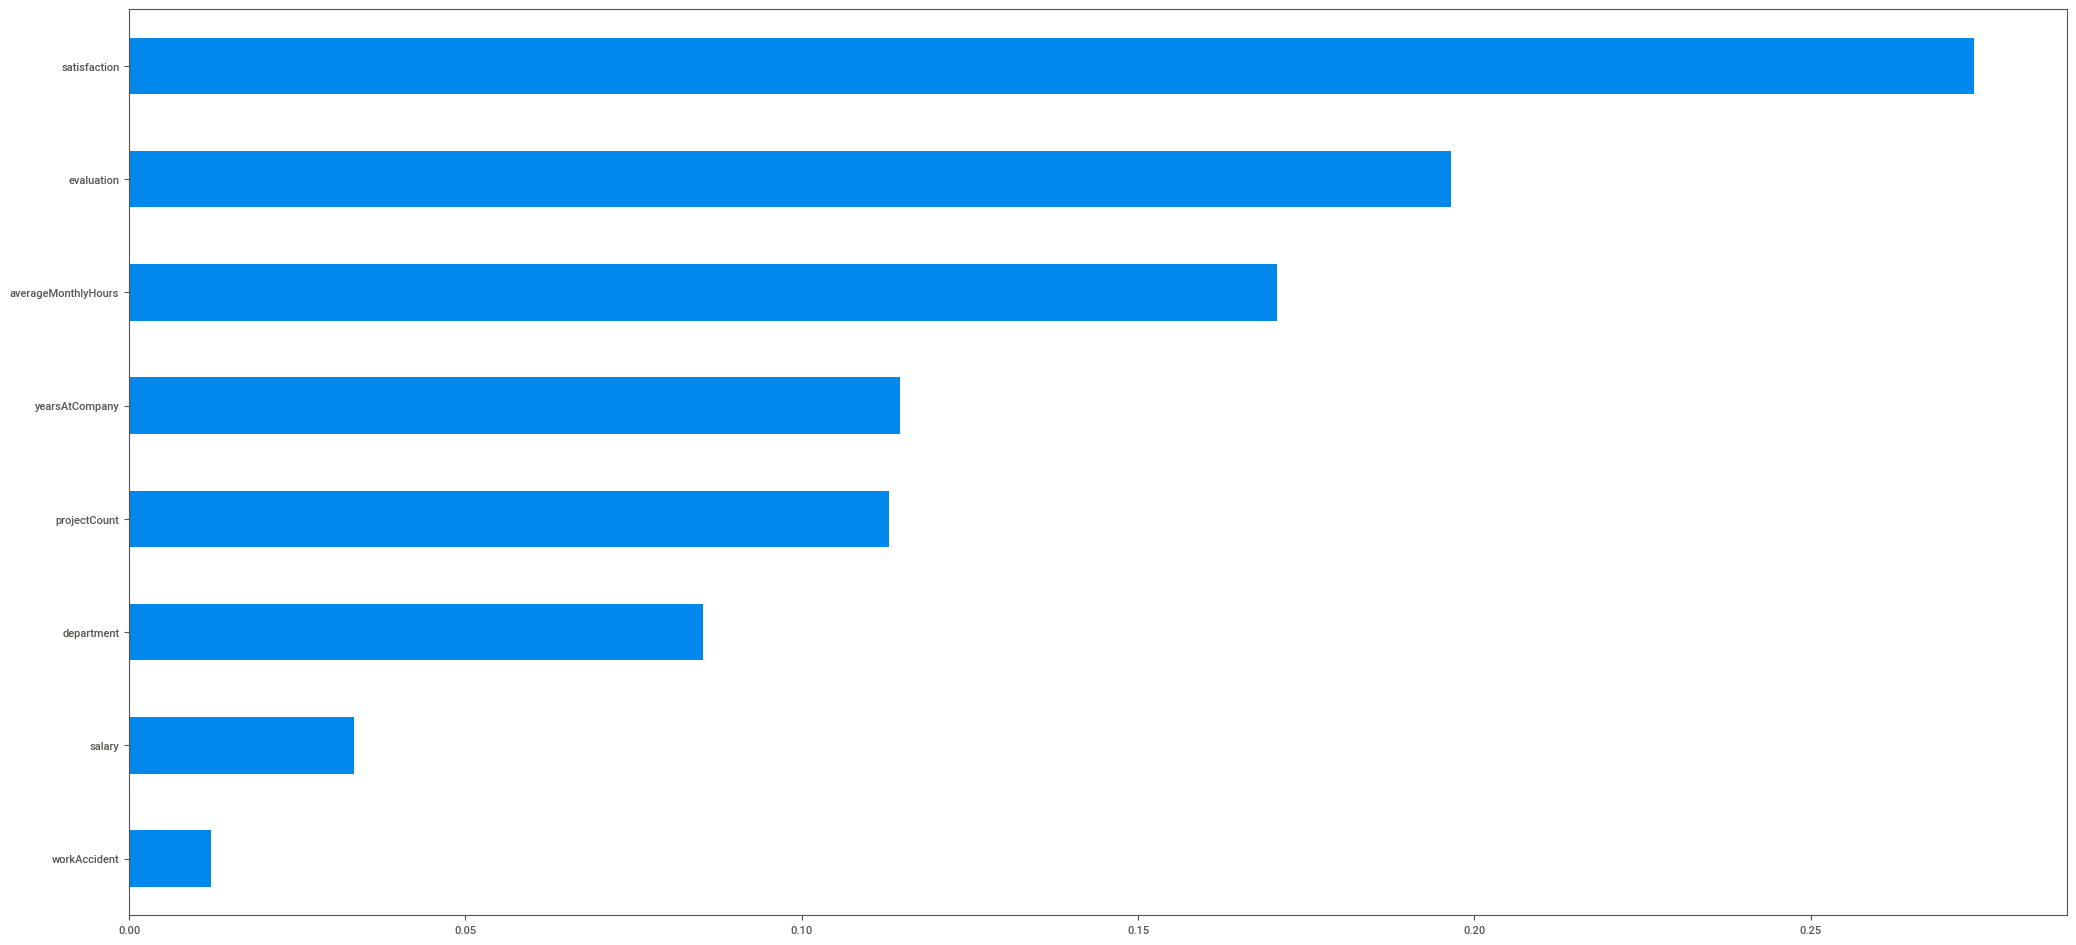

In [147]:
#feature importances 
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')

# 5.0. MACHINE LEARNING MODELLING

In [174]:
X_train = X_train[['projectCount', 'satisfaction', 'evaluation', 'yearsAtCompany']]
X_test =  X_test[['projectCount', 'satisfaction', 'evaluation', 'yearsAtCompany']]

## 5.1. Logistic Regression

In [175]:
#define model
logreg = LogisticRegression()

#training model
logreg.fit(X_train.values,y_train.values.ravel())

#predict
yhat_log = logreg.predict(X_test) 

# AUC-ROC
logreg_cv = cross_val_predict(logreg, X_train, y_train, cv=5, method='decision_function')
logreg_roc = roc_auc_score(y_train, logreg_cv)

#performance
result_log = pd.DataFrame(["Logistic Regression",accuracy_score(y_test,yhat_log),cohen_kappa_score(y_test,yhat_log),
                          recall_score(y_test,yhat_log), f1_score(y_test,yhat_log),
                           precision_score(y_test,yhat_log), logreg_roc]).T
result_log.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","Precision_score","roc_auc_score"]

#classification_report
print(classification_report(y_test, yhat_log))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      2286
           1       0.27      0.05      0.08       714

    accuracy                           0.74      3000
   macro avg       0.52      0.50      0.46      3000
weighted avg       0.65      0.74      0.67      3000



In [176]:
#performance logistic regression
result_log

Model Accuracy Kappa Score    Recall  F1-Score Precision_score roc_auc_score
0  Logistic Regression    0.743    0.009573  0.046218  0.078853        0.268293      0.694539

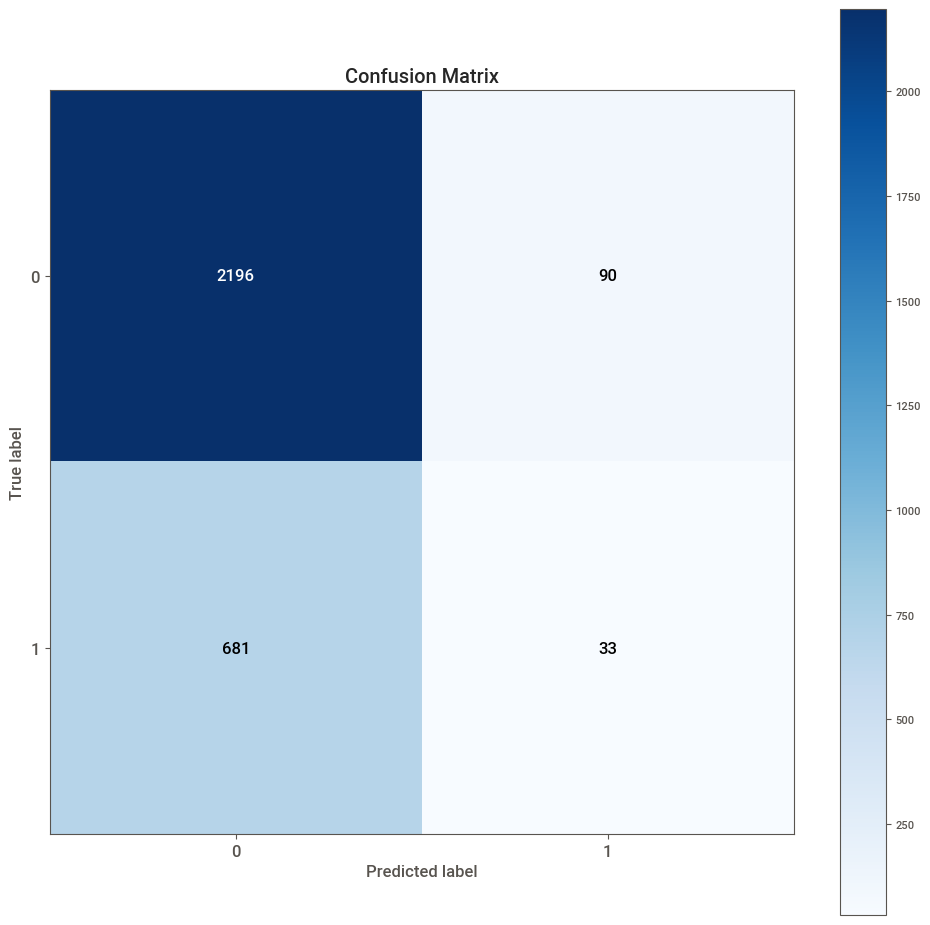

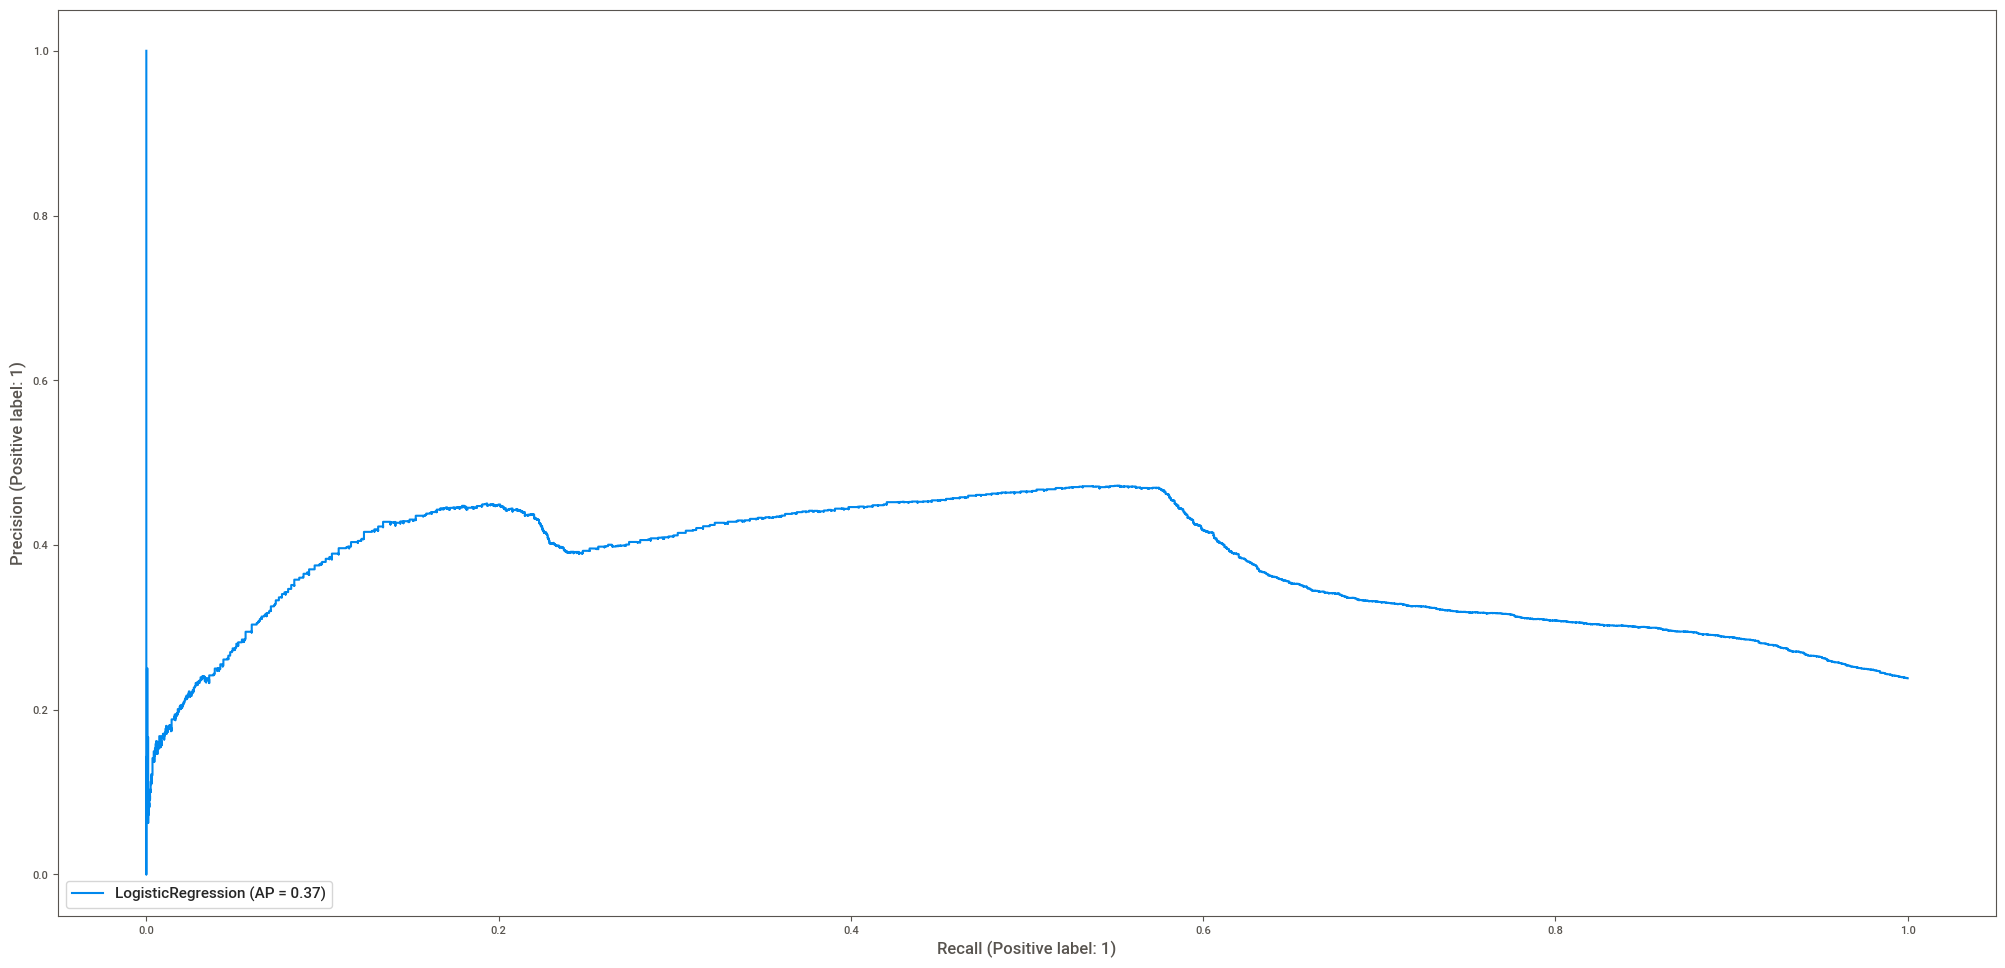

In [177]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_log, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(logreg, X_train, y_train)

In [178]:
#cross validation scores
log_cv = cross_val_score(logreg,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(log_cv),4),np.round(np.std(log_cv),4)))

Average: 0.7452 +/- Std 0.004


## 5.2. XGBoost Classifier

In [179]:
#model definition
xgb_model = xgb.XGBClassifier(n_jobs = -1)

#fit model
xgb_model.fit(X_train,y_train)

#prediction
yhat_xgb = xgb_model.predict(X_test)

# AUC-ROC
xgb_cv = cross_val_predict(xgb_model, X_train, y_train, cv=5)
xgb_roc = roc_auc_score(y_train, xgb_cv)


#performance
result_xgb = pd.DataFrame(["XGBoost Classifier",accuracy_score(y_test,yhat_xgb),cohen_kappa_score(y_test,yhat_xgb),
                          recall_score(y_test,yhat_xgb), f1_score(y_test,yhat_xgb),xgb_roc,
                          precision_score(y_test,yhat_xgb)]).T
result_xgb.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_xgb))

[00:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [180]:
#summary metrics
result_xgb

Model Accuracy Kappa Score    Recall F1-Score roc_auc_score Precision_score
0  XGBoost Classifier    0.844    0.560164  0.640056  0.66136      0.773887        0.684132

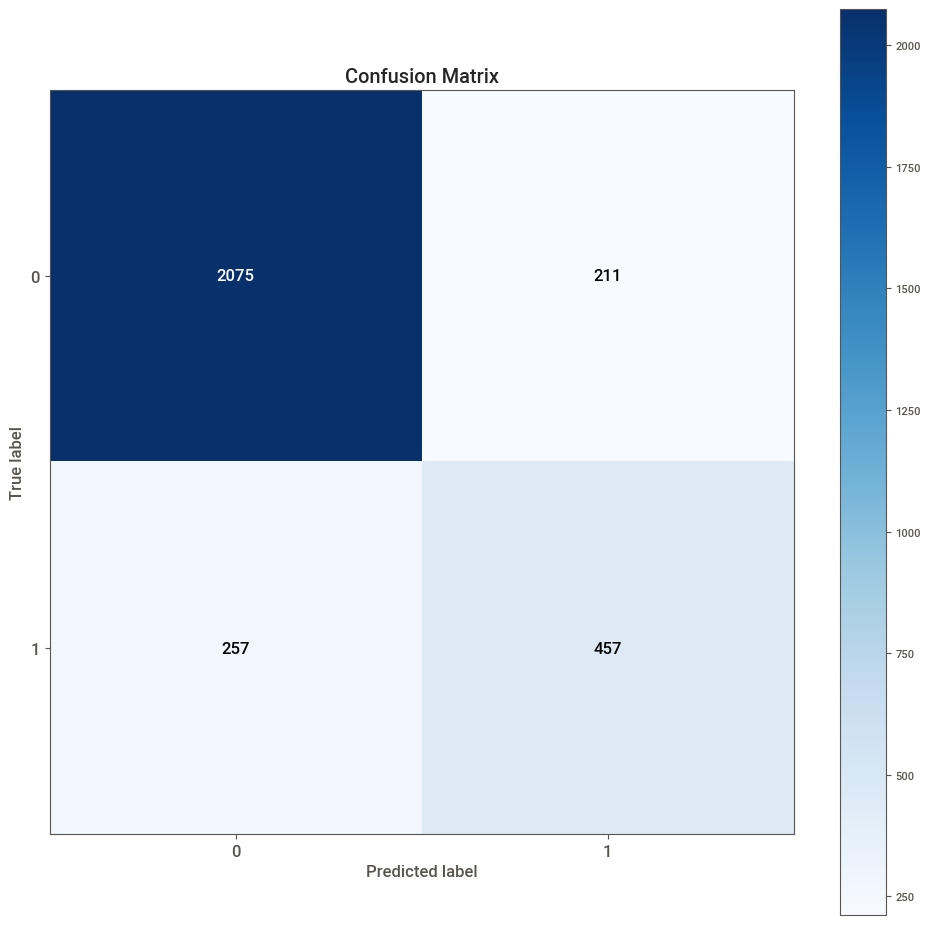

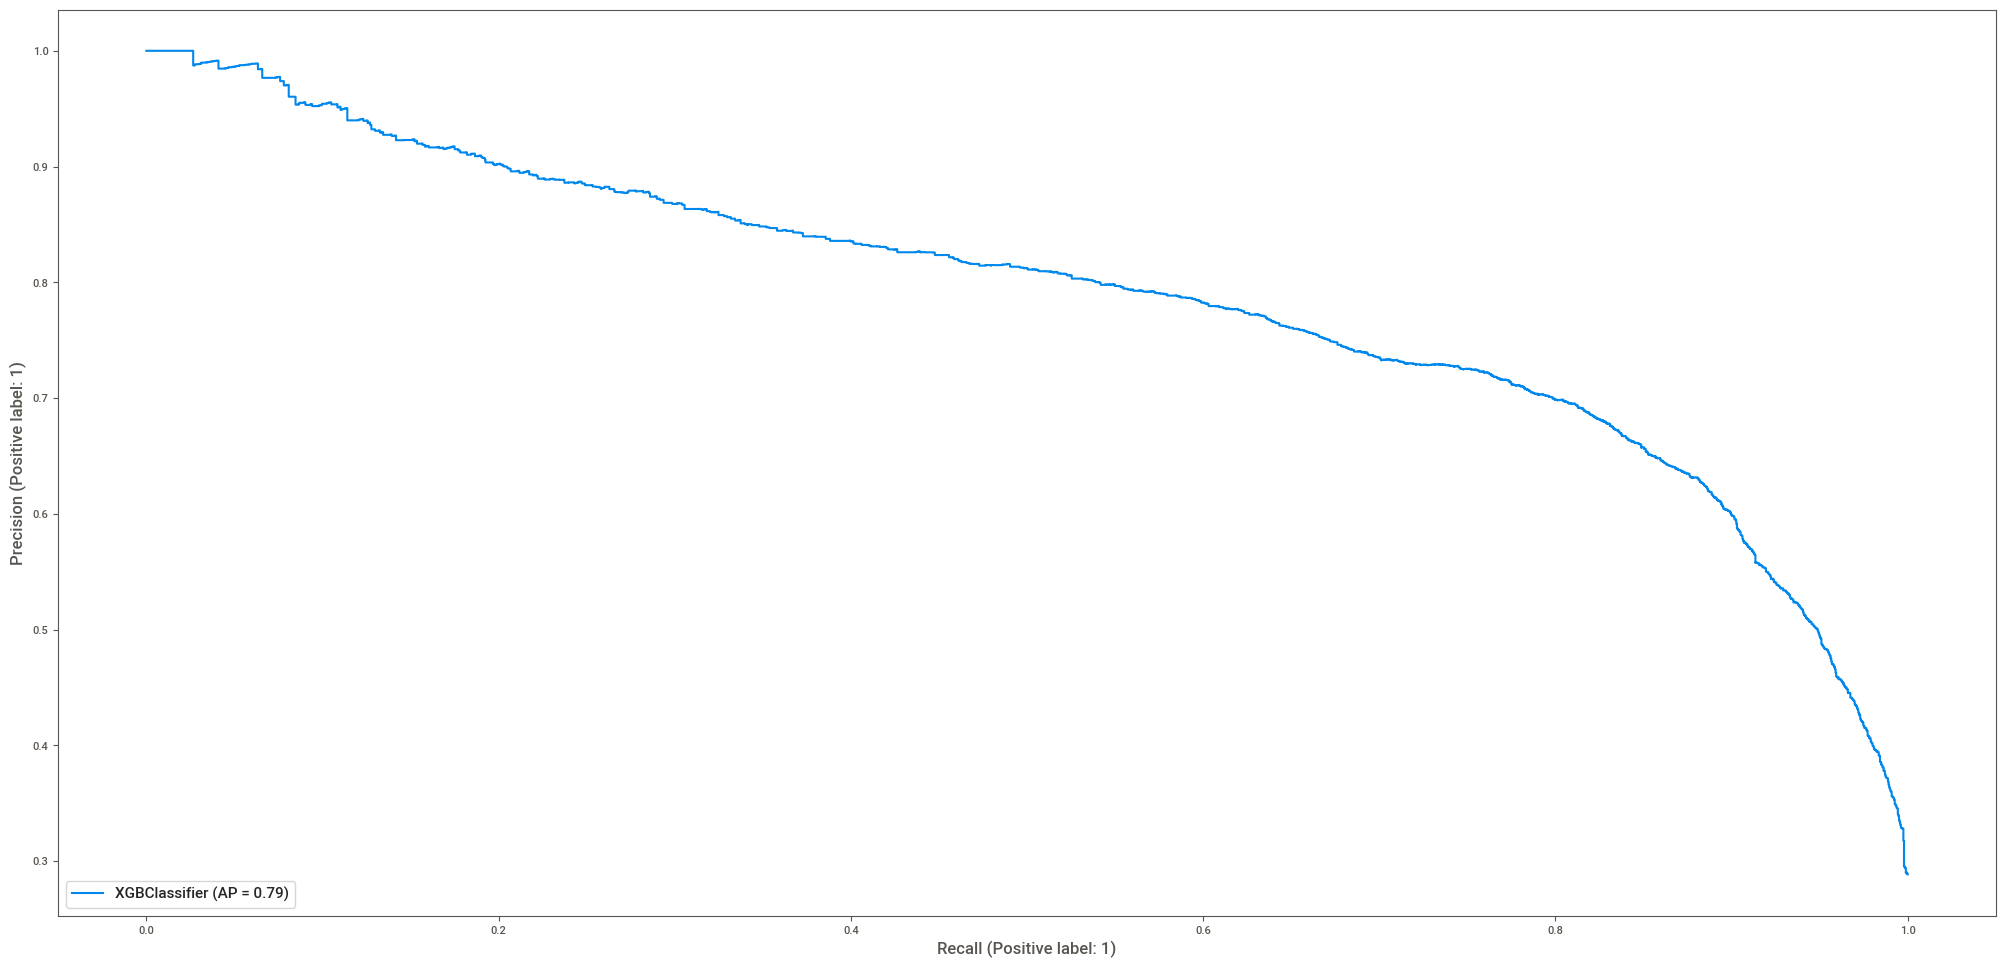

In [181]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_xgb, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(xgb_model, X_train, y_train)

In [182]:
#cross validation scores
xgb_cv = cross_val_score(xgb_model,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(xgb_cv),4),np.round(np.std(xgb_cv),4)))

Average: 0.8454 +/- Std 0.0076


## 5.3. LGBM Classifier

In [183]:
#define model
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

#training model
model_lgbm.fit(X_train, y_train)

#predict model
yhat_lgbm = model_lgbm.predict(X_test)

# AUC-ROC
lgbm_cv = cross_val_predict(model_lgbm, X_train, y_train, cv=5)
lgbm_roc = roc_auc_score(y_train, lgbm_cv)


#performance
result_lgbm = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm),cohen_kappa_score(y_test,yhat_lgbm),
                          recall_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),lgbm_roc,
                           precision_score(y_test,yhat_lgbm)]).T
result_lgbm.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2286
           1       0.69      0.64      0.67       714

    accuracy                           0.85      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.84      0.85      0.85      3000



In [184]:
#result lgbg
result_lgbm

Model Accuracy Kappa Score    Recall F1-Score roc_auc_score Precision_score
0  LGBM Classifier    0.847    0.567984  0.644258  0.66715      0.787658        0.691729

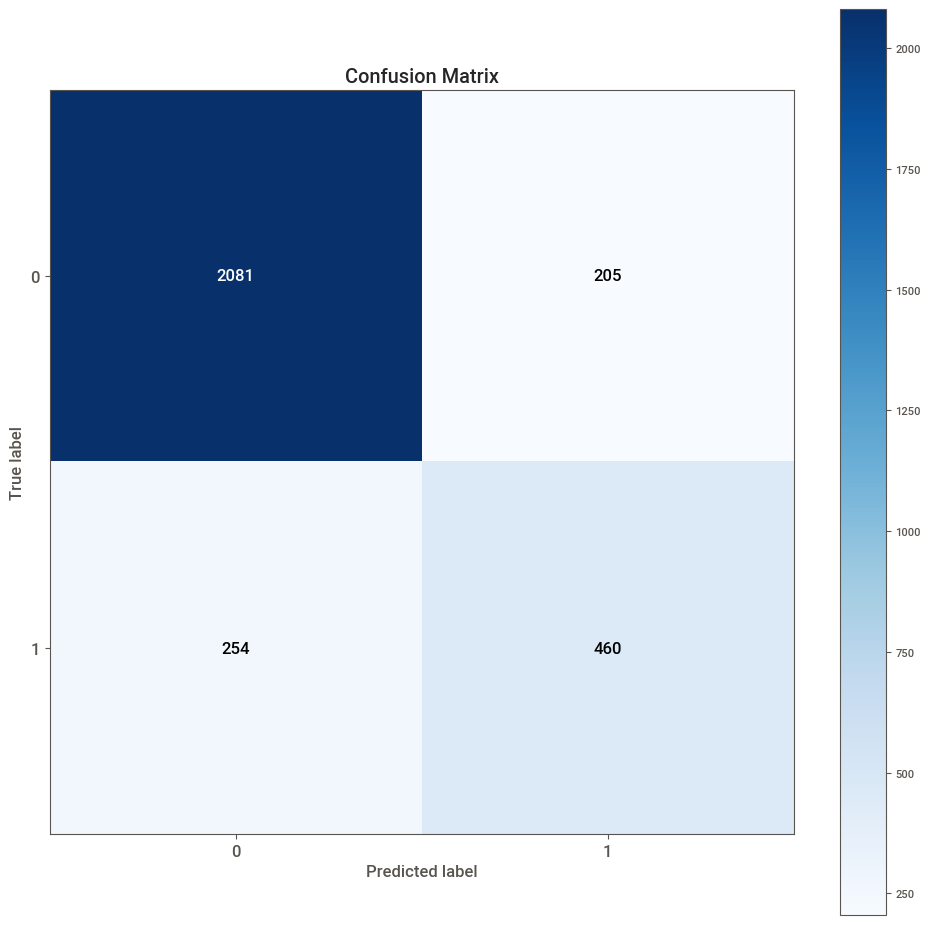

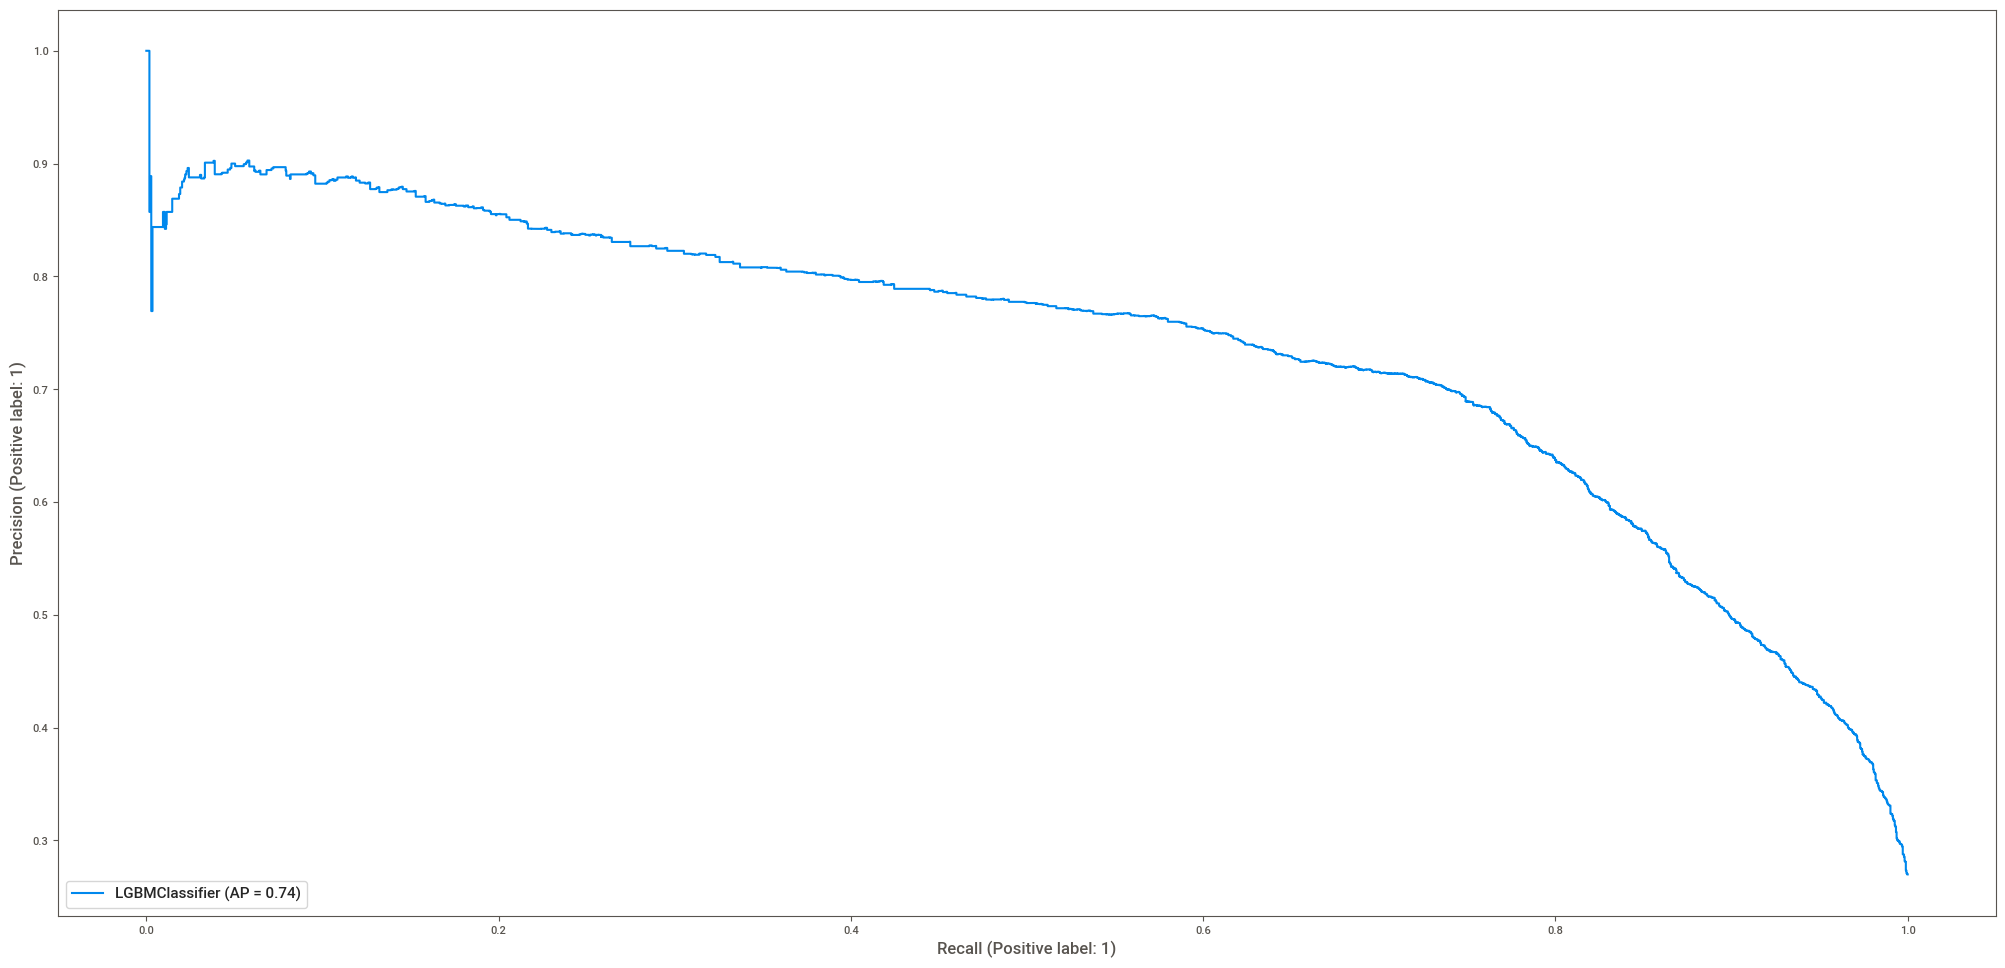

In [185]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_lgbm, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(model_lgbm, X_train, y_train)

In [186]:
#cross validation scores
lgbm_cv = cross_val_score(model_lgbm,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(lgbm_cv),4),np.round(np.std(lgbm_cv),4)))

Average: 0.8545 +/- Std 0.0093


## 5.4. Random Forest Classifier

In [187]:
#define model
rf = RandomForestClassifier(n_jobs = -1)

#training model
rf.fit(X_train, y_train)

#predict model
yhat_rf = rf.predict(X_test)

# AUC-ROC
rf_cv = cross_val_predict(rf, X_train, y_train, cv=5)
rf_roc = roc_auc_score(y_train, rf_cv)

#performance
result_rf = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf),cohen_kappa_score(y_test,yhat_rf),
                          recall_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),rf_roc,
                           precision_score(y_test,yhat_rf)]).T
result_rf.columns = ["Model",'Accuracy',"Kappa Score","Recall","F1-Score","roc_auc_score","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2286
           1       0.62      0.60      0.61       714

    accuracy                           0.82      3000
   macro avg       0.75      0.74      0.74      3000
weighted avg       0.82      0.82      0.82      3000



In [188]:
result_rf

Model  Accuracy Kappa Score    Recall F1-Score roc_auc_score Precision_score
0  Random Forest Classifier  0.817333    0.490001  0.598039  0.60913      0.737025         0.62064

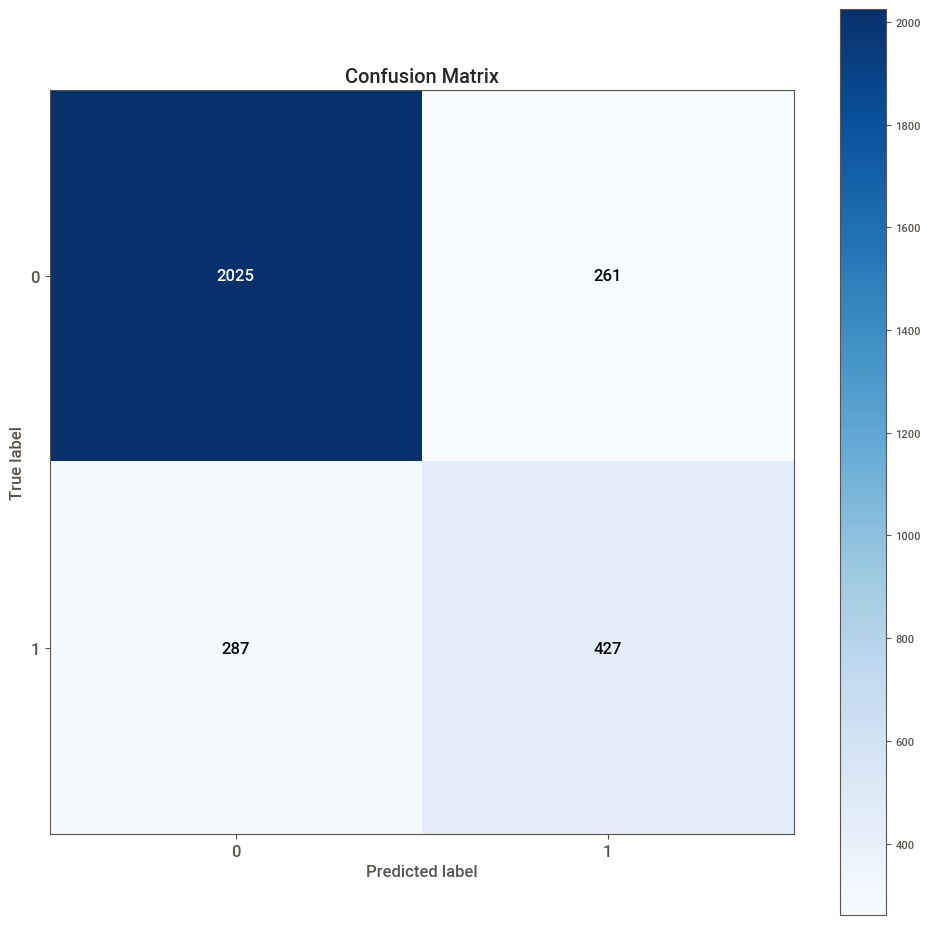

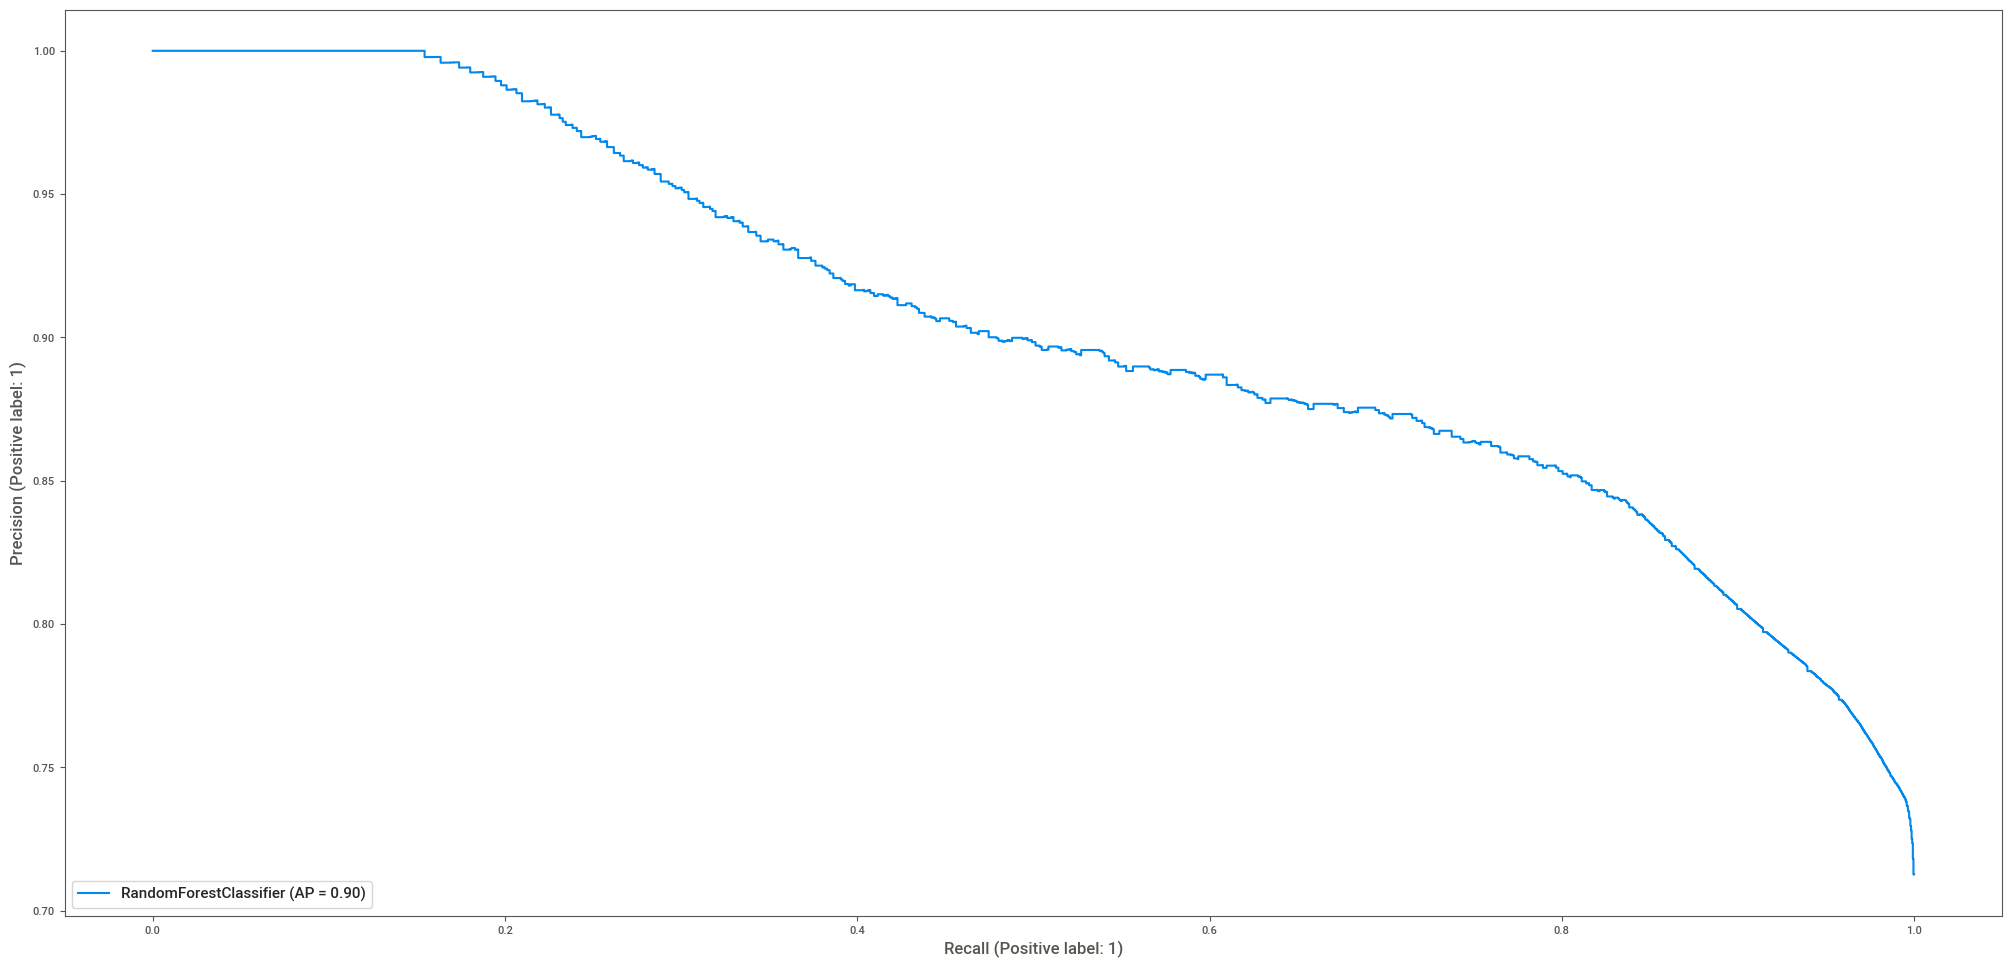

In [189]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_rf, normalize = False, figsize = (12,12))

#precision_recall_curve
plot_precision_recall_curve(rf, X_train, y_train)

In [190]:
#cross validation scores
rf_cv = cross_val_score(rf,X_train, y_train.ravel(), cv = 10, n_jobs = -1)

#mean and standard deviation
print("Average: {} +/- Std {}".format(np.round(np.mean(rf_cv),4),np.round(np.std(rf_cv),4)))

Average: 0.8218 +/- Std 0.0104


## 5.5. Summary Metrics

### 5.5.1. Metrics

In [191]:
#concat all the models as a dataframe
result_model = pd.concat([result_log,result_xgb,result_lgbm,result_rf])
result_model.sort_values("Accuracy", ascending = False)

Model  Accuracy Kappa Score    Recall  F1-Score Precision_score roc_auc_score
0           LGBM Classifier     0.847    0.567984  0.644258   0.66715        0.691729      0.787658
0        XGBoost Classifier     0.844    0.560164  0.640056   0.66136        0.684132      0.773887
0  Random Forest Classifier  0.817333    0.490001  0.598039   0.60913         0.62064      0.737025
0       Logistic Regression     0.743    0.009573  0.046218  0.078853        0.268293      0.694539

### 5.5.2. ROC Curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.682
LGBM: ROC AUC=0.796
XGBoostClassifier: ROC AUC=0.799
RandomForestClassifier: ROC AUC=0.795


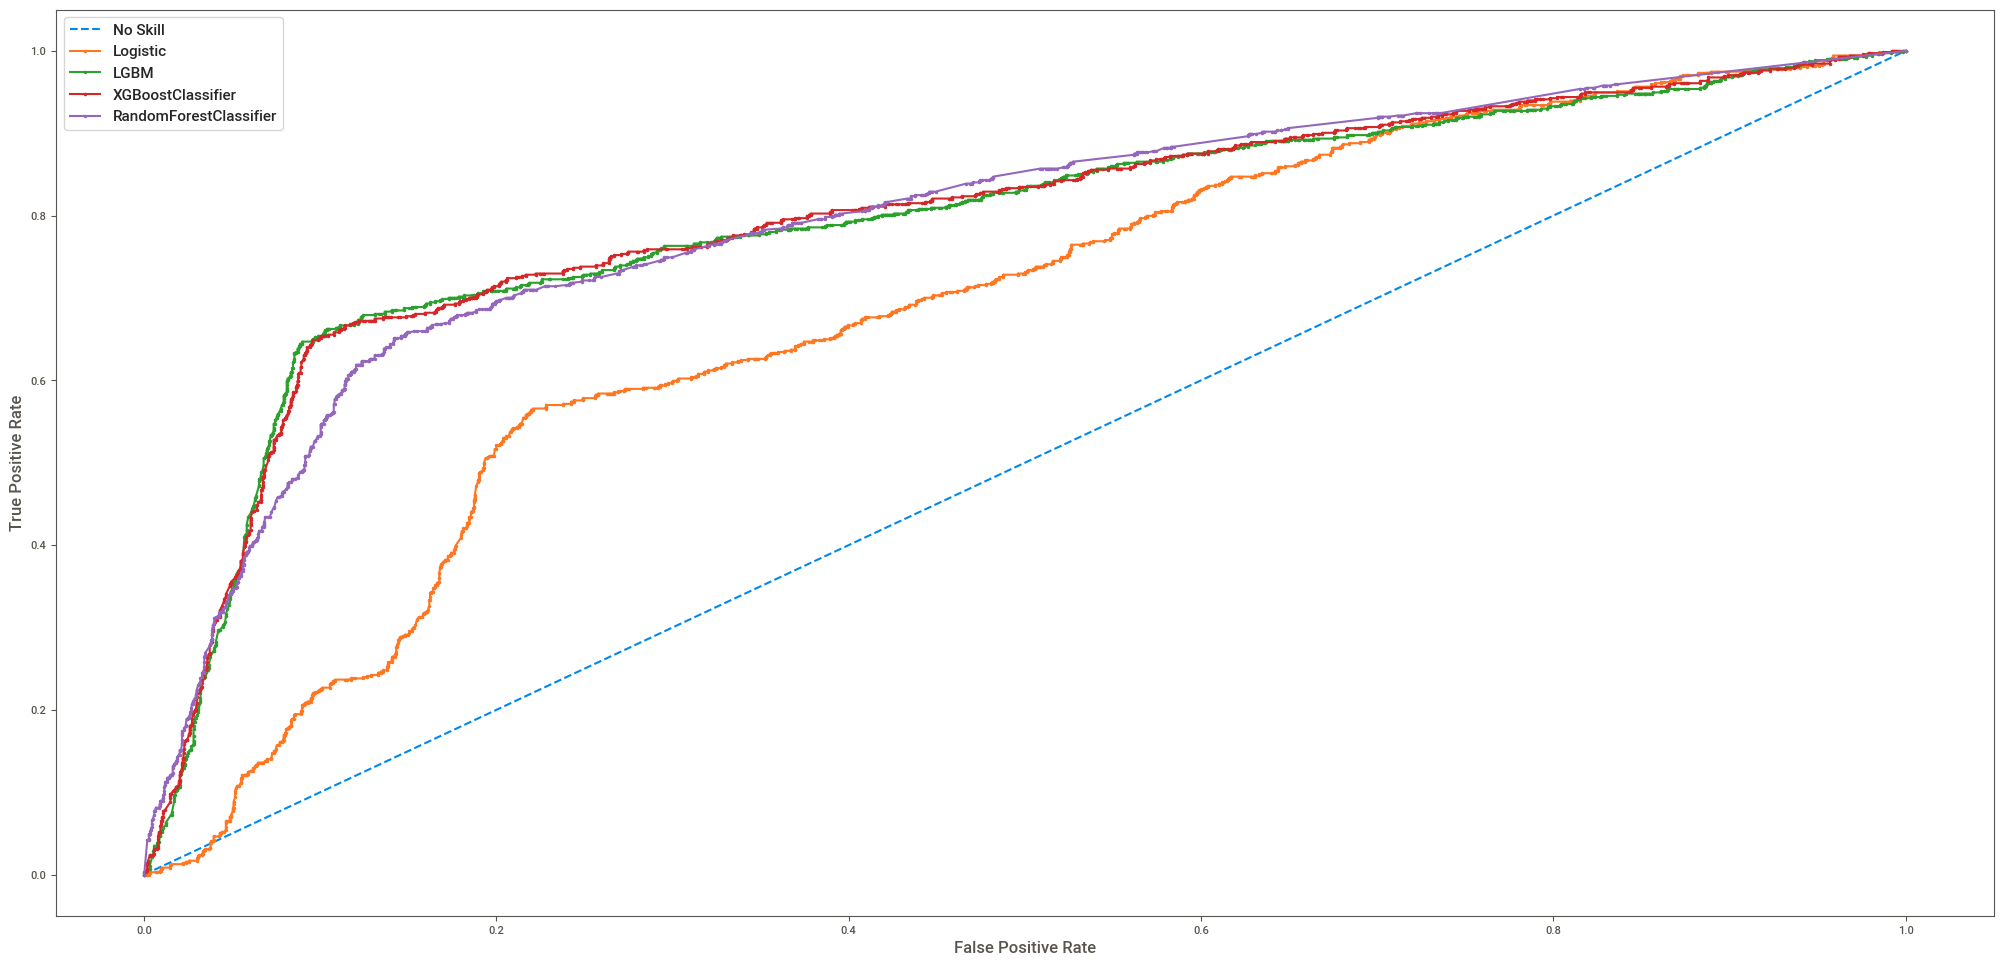

In [192]:
#machine leraning model
lr_probs = logreg.predict_proba(X_test)
lgbm_probs = model_lgbm.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)


# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_probs[:, 1]
lgbm_probs = lgbm_probs[:,1]
xgb_probs = xgb_probs[:,1]
rf_probs = rf_probs[:,1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('LGBM: ROC AUC=%.3f' % (lgbm_auc))
print('XGBoostClassifier: ROC AUC=%.3f' % (xgb_auc))
print('RandomForestClassifier: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

#plot
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoostClassifier')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForestClassifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# 6.0. HYPERPARAMETER FINE TUNNING

In [193]:
#define model
model_lgbm = LGBMClassifier(n_jobs = -1, random_state = 42)

#parameters
parameters = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

#define RandomSearchCV
lgbm_random_cv = RandomizedSearchCV(estimator=model_lgbm, param_distributions=parameters,
                                scoring='accuracy', n_iter=100, cv=10, verbose=2,
                                random_state=42, n_jobs=-1)

#fit RandomSearchCV
lgbm_random_cv.fit(X_train, np.ravel(y_train))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_depth': arr...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,  16,  64, 256], dtype=int32),
                                        'subsample': array([0.25      , 0.30357

In [194]:
#get the best parameters to our model
lgbm_random_cv.best_estimator_

LGBMClassifier(colsample_bytree=0.775, learning_rate=0.2149285714285714,
               max_depth=4, min_data_in_leaf=100, n_estimators=70,
               num_leaves=256, random_state=42, subsample=0.7321428571428571)

## 6.2. Fit the model using the best parameters

In [195]:
#define model
lgbm_hyper = LGBMClassifier(colsample_bytree=0.775, learning_rate=0.2149285714285714,
               max_depth=4, min_data_in_leaf=100, n_estimators=70,
               num_leaves=256, random_state=42, subsample=0.7321428571428571)

#fit model
lgbm_hyper.fit(X_train, y_train)

#predict model
yhat_lgbm_hyper = lgbm_hyper.predict(X_test)

#Performance
#performance
result_lgbm_hyper = pd.DataFrame(["LGBM Classifier",lgbm_random_cv.best_score_,accuracy_score(y_test,yhat_lgbm_hyper),cohen_kappa_score(y_test,yhat_lgbm_hyper),
                          recall_score(y_test,yhat_lgbm_hyper), f1_score(y_test,yhat_lgbm_hyper),lgbm_auc,
                           precision_score(y_test,yhat_lgbm_hyper)]).T
result_lgbm_hyper.columns = ["Model",'Best Score','Accuracy',"Kappa Score","Recall","F1-Score","ROC_AUC","Precision_score"]

#classification_report
print(classification_report(y_test, yhat_lgbm_hyper))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2286
           1       0.69      0.64      0.66       714

    accuracy                           0.84      3000
   macro avg       0.79      0.77      0.78      3000
weighted avg       0.84      0.84      0.84      3000



In [196]:
result_lgbm_hyper

Model Best Score  Accuracy Kappa Score    Recall  F1-Score   ROC_AUC Precision_score
0  LGBM Classifier   0.855072  0.844667    0.560745  0.637255  0.661337  0.795508        0.687311

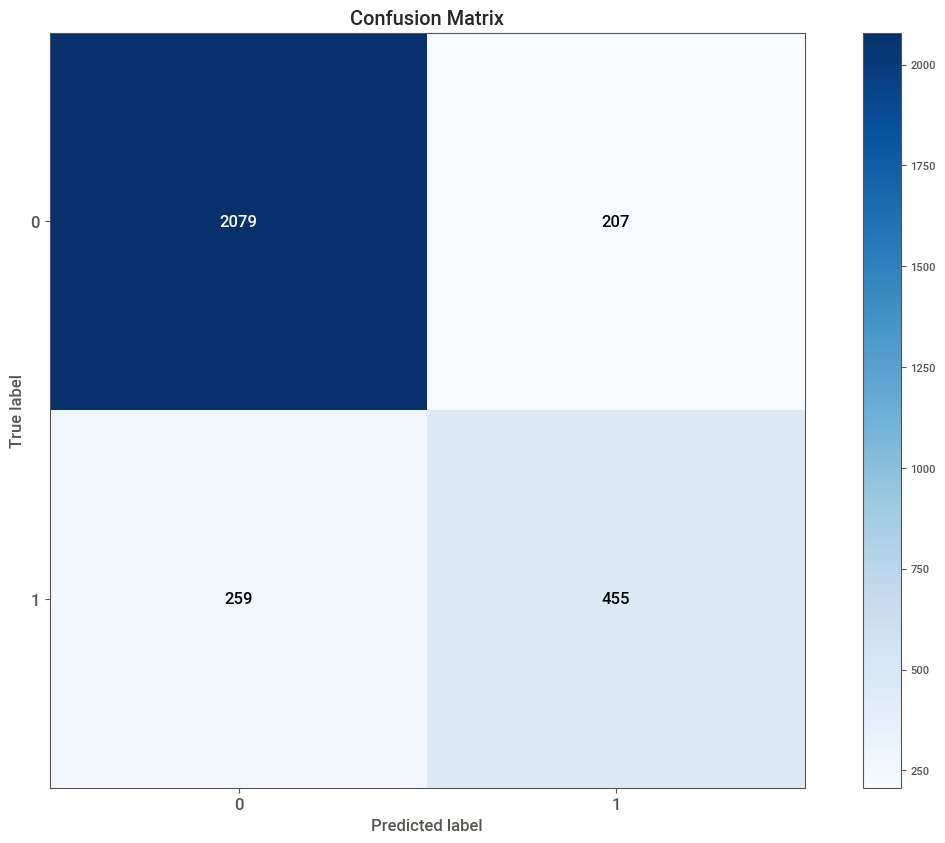

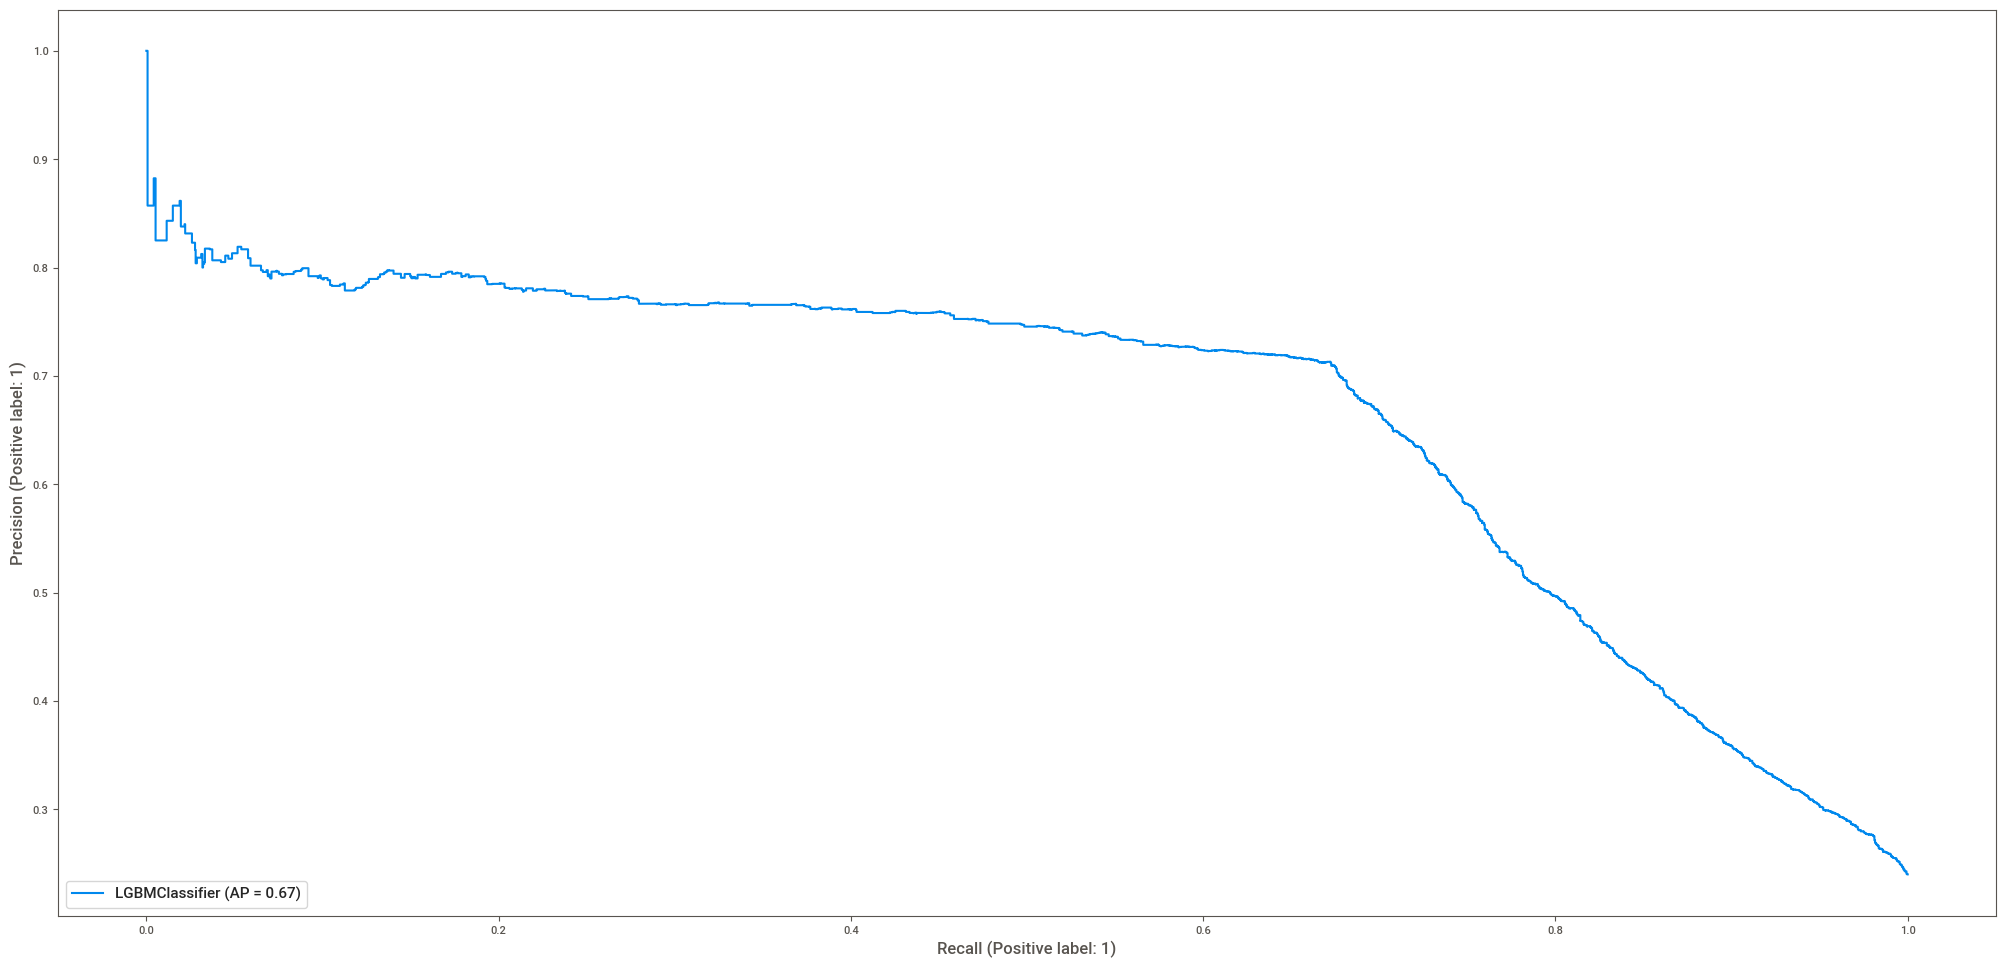

In [197]:
#confusion_matrix
mt.plot_confusion_matrix(y_test,yhat_lgbm_hyper, normalize = False, figsize = (15,10))

#precision_recall_curve
plot_precision_recall_curve(lgbm_hyper, X_train, y_train)

In [200]:
pickle.dump(lgbm_hyper, open("model.pkl", "wb"))

# 7.0. FIT PIPELINE WITH PYCARET

In [207]:
s = setup( df2[["satisfaction","evaluation","averageMonthlyHours","yearsAtCompany","turnover"]]
          ,target = "turnover"
          ,numeric_features = ["yearsAtCompany"]
          ,normalize = True
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
         )

NameError: name 'setup' is not defined

In [224]:
df2.sample(10)

department  salary  averageMonthlyHours  projectCount  satisfaction  evaluation  yearsAtCompany  workAccident  turnover
10677        sales     low                  278             2          52.0        37.0               2             0         0
8648   product_mng     low                  262             4          95.0        67.0               2             0         1
9193            IT     low                  285             2          66.0        54.0               2             0         1
9106     technical     low                  286             3          73.0        77.0               2             0         0
6416         sales     low                  276             3          39.0        43.0               3             0         1
10325           IT  medium                  273             4          99.0        89.0               3             1         0
1764     marketing     low                  280             2          36.0        54.0               3             0         1
14815   accounting    high                  248             6          11.0        79.0               4             0         0
7876   product_mng  medium                  277             6          16.0        76.0               6             0         0
8177       support     low                  284             6          49.0        67.0               4             0         0

# 8.0. SEND BEST MODEL TO DATA LAKE 

In [201]:
client.fput_object("curated","model.pkl","model.pkl")

In [204]:
df2.to_csv("dataset.csv", index = False)
client.fput_object("curated","dataset.csv","dataset.csv")